### **`Business Understanding`**

**Objective**: The primary objective of this project is to predict fluctuations in the U.S. Dollar Index (DXY) using historical prices of Bitcoin, crude oil, and gold, alongside other influential factors such as economic trends and temporal variables. Additionally, the project aims to utilize these predictions to calculate and assess portfolio risk, providing actionable insights for more informed investment strategies.

**Key Questions:**
1. What are the relationships between Bitcoin, crude oil, and gold prices, and how do they correlate with changes in the U.S. Dollar Index?
2.	To what extent do external features, such as holidays, weekdays, or the DXY itself, influence the accuracy and predictive power of the model?
3.	How can the predictive model be used to calculate and evaluate portfolio risk, helping investors optimize their asset allocation?
4.	What actionable insights can the predictive model offer for market forecasting and portfolio management strategies?

### **`Data Understanding`**

**Objective**: merging different datasets into one

#### **Separate Dataset Preprocessing**
- At the End of this stage we will have different cleaned DataFrames, ready for a left join By date.
    - Standardize column names
    - Proper Dtypes
    - Date properties (holiday, weekday) changed to binary
    - Ensured about date Integrity for all DFs

#### **Importation of Packages**

In [521]:
# Data Manipulations & Visualization
import pandas as pd
from dateutil import parser
from datetime import datetime
import holidays
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import plotly.express as px
import math

# Time Series Analysis Packages
from statsmodels.tsa.seasonal import seasonal_decompose

#Data Preparation
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Machine Learning Packages
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier, ExtraTreesClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
# import shap
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Evaluation & Model Persistance
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import joblib

#Utilities
import warnings
import os

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
pd.set_option('display.max_columns' , None)
pd.set_option('display.max_rows' , None)

#### **Loading dataset**

In [522]:
oil_path = 'https://raw.githubusercontent.com/coderacheal/Inter-Market-Dynamics-Gold-Oil-Bitcoin-Dollar-Index/refs/heads/main/datasets/cleaned_oil.csv'
gold_path = 'https://raw.githubusercontent.com/coderacheal/Inter-Market-Dynamics-Gold-Oil-Bitcoin-Dollar-Index/refs/heads/main/datasets/cleaned_gold.csv'
btc_path = 'https://raw.githubusercontent.com/coderacheal/Inter-Market-Dynamics-Gold-Oil-Bitcoin-Dollar-Index/refs/heads/main/datasets/cleaned_btc.csv'
dxy_path = 'https://raw.githubusercontent.com/coderacheal/Inter-Market-Dynamics-Gold-Oil-Bitcoin-Dollar-Index/refs/heads/main/datasets/cleaned_dxy.csv'
date_path = 'https://raw.githubusercontent.com/coderacheal/Inter-Market-Dynamics-Gold-Oil-Bitcoin-Dollar-Index/refs/heads/main/datasets/date.csv'
holiday_path = 'https://raw.githubusercontent.com/coderacheal/Inter-Market-Dynamics-Gold-Oil-Bitcoin-Dollar-Index/refs/heads/main/datasets/holiday.csv'

In [523]:
df_oil = pd.read_csv(oil_path)
df_gold = pd.read_csv(gold_path)
df_dxy = pd.read_csv(dxy_path)
df_btc = pd.read_csv(btc_path)
df_date = pd.read_csv(date_path)
df_holiday = pd.read_csv(holiday_path)

##### **Oil DataFrame Preprocessing**

In [524]:
df_oil.head()

,Date,oil_close,oil_open,oil_high,oil_low
0,2024-11-06,71.83,72.07,72.63,69.75
1,2024-11-05,71.99,71.62,72.67,71.29
2,2024-11-04,71.47,70.29,71.81,70.25
3,2024-11-01,69.49,70.44,71.45,69.32
4,2024-10-31,69.26,69.10,70.81,68.30


In [525]:
df_oil.dtypes

Date          object
oil_close    float64
oil_open     float64
oil_high     float64
oil_low      float64
dtype: object

In [526]:
# Convert Date to datetime
df_oil['Date'] = pd.to_datetime(df_oil['Date'])

In [527]:
df_oil.shape

(2858, 5)

In [528]:
# Check for start and end date
df_oil['Date'].min(), df_oil['Date'].max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2024-11-06 00:00:00'))

##### **Gold DataFrame Preprocessing**

In [529]:
df_gold.head()

,Date,gold_close,gold_open,gold_high,gold_low
0,2024-11-06,"2,668.00","2,754.40","2,758.70","2,660.75"
1,2024-11-05,"2,749.70","2,746.00","2,759.50","2,733.40"
2,2024-11-04,"2,746.20","2,743.50","2,757.50","2,739.40"
3,2024-11-01,"2,749.20","2,754.00","2,772.40","2,742.60"
4,2024-10-31,"2,749.30","2,799.10","2,801.20","2,741.80"


In [530]:
df_gold.dtypes

Date          object
gold_close    object
gold_open     object
gold_high     object
gold_low      object
dtype: object

In [531]:
# Convert Date to datetime
df_gold['Date'] = pd.to_datetime(df_gold['Date'])

In [532]:
# Covert Object to Float
for col in ["gold_close", "gold_open", "gold_high", "gold_low"]:
    df_gold[col] = df_gold[col].str.replace(',', '').astype(float)

In [533]:
df_gold.shape

(2568, 5)

In [534]:
# Check for start and end date
df_gold['Date'].min(), df_gold['Date'].max()

(Timestamp('2014-11-03 00:00:00'), Timestamp('2024-11-06 00:00:00'))

##### **Btc (Bitcoin) DataFrame Preprocessing**

In [535]:
df_btc.head()

,Unnamed: 0,Date,btc_open,btc_high,btc_low,btc_close
0,0,2024-10-21,69009.37,69408.10,66873.84,67525.97
1,1,2024-10-20,68364.18,69359.01,68105.72,69001.70
2,2,2024-10-19,68418.98,68668.01,68024.64,68362.73
3,3,2024-10-18,67419.11,68969.75,67177.82,68418.79
4,4,2024-10-17,67617.08,67912.21,66647.39,67399.84


In [536]:
df_btc.dtypes

Unnamed: 0      int64
Date           object
btc_open      float64
btc_high      float64
btc_low       float64
btc_close     float64
dtype: object

In [537]:
df_btc = df_btc.drop(columns=['Unnamed: 0'])

In [538]:
df_btc.shape

(3643, 5)

In [539]:
# Convert Date to datetime
df_btc['Date'] = pd.to_datetime(df_btc['Date'])

In [540]:
# Check for start and end date
df_gold['Date'].min(), df_gold['Date'].max()

(Timestamp('2014-11-03 00:00:00'), Timestamp('2024-11-06 00:00:00'))

##### **DXY DataFrame Preprocessing**

In [541]:
df_dxy.head()

,Date,dxy_close,dxy_open,dxy_high,dxy_low,Vol.,Change %
0,2024-11-06,105.16,103.70,105.44,103.70,NaN,1.68%
1,2024-11-05,103.42,103.91,103.96,103.37,NaN,-0.45%
2,2024-11-04,103.89,104.32,103.97,103.58,NaN,-0.37%
3,2024-11-01,104.28,103.86,104.35,103.68,NaN,0.29%
4,2024-10-31,103.98,104.08,104.22,103.82,NaN,-0.01%


In [542]:
# drop  vol, change columns
df_dxy = df_dxy.drop(columns=['Vol.', 'Change %'])

In [543]:
df_dxy.dtypes

Date          object
dxy_close    float64
dxy_open     float64
dxy_high     float64
dxy_low      float64
dtype: object

In [544]:
# Convert Date to datetime
df_dxy['Date'] = pd.to_datetime(df_dxy['Date'])

In [545]:
df_dxy.shape

(2832, 5)

In [546]:
# Check for start and end date
df_dxy['Date'].min(), df_dxy['Date'].max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2024-11-06 00:00:00'))

##### **Date DataFrame Preprocessing**

In [547]:
df_date.head()

,Unnamed: 0,Date,DoW,Month,Year
0,0,2014-11-01,Saturday,11,2014
1,1,2014-11-02,Sunday,11,2014
2,2,2014-11-03,Monday,11,2014
3,3,2014-11-04,Tuesday,11,2014
4,4,2014-11-05,Wednesday,11,2014


In [548]:
df_date = df_date.drop(columns=['Unnamed: 0'])

In [549]:
df_date['Date'] = pd.to_datetime(df_date['Date'])

In [550]:
df_date.shape

(3653, 4)

In [551]:
df_date['Date'].min(), df_date['Date'].max()

(Timestamp('2014-11-01 00:00:00'), Timestamp('2024-10-31 00:00:00'))

##### **Holiday DataFrame Preprocessing**

In [552]:
df_holiday = df_holiday[['Date','Title']]

In [553]:
df_holiday['Date'] = pd.to_datetime(df_holiday['Date'])

In [554]:
df_holiday.dtypes

Date     datetime64[ns]
Title            object
dtype: object

##### **Weekday DataFrame Creating**

In [555]:
# Define the date range (10 years)
start_date = datetime(2014, 1, 1)  # Start of the range
end_date = datetime(2024, 11, 6)    # End of the range
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

In [556]:
# Create a DataFrame with the date range
df_weekday = pd.DataFrame(date_range, columns=["Date"])

# Add a column indicating whether each date is a weekday
df_weekday["is_weekday"] = df_weekday["Date"].dt.weekday < 5  # Monday=0, Sunday=6

# Initialize the holidays for a specific country (e.g., United States)
us_holidays = holidays.UnitedStates(years=range(2014, 2025))

# Add a column indicating whether each date is a holiday
df_weekday["is_holiday"] = df_weekday["Date"].dt.date.isin(us_holidays)

In [557]:
df_weekday["is_weekday"] = df_weekday["is_weekday"].astype(int)
df_weekday["is_holiday"] = df_weekday["is_holiday"].astype(int)

In [558]:
df_weekday.tail()

,Date,is_weekday,is_holiday
3958,2024-11-02,0,0
3959,2024-11-03,0,0
3960,2024-11-04,1,0
3961,2024-11-05,1,0
3962,2024-11-06,1,0


#### **Joining Stage**
- The Final Table
    - Daily Open, High, Low, Close Prices of commodities 
    - Daily Open, High, Low, Close Prices of Dollar Index
    - Date properties (holiday, weekday)
    - Proper Dtypes

In [559]:
# merge all dataframes
df = df_date \
    .merge(df_btc, on='Date', how='left') \
    .merge(df_oil, on='Date', how='left') \
    .merge(df_gold, on='Date', how='left') \
    .merge(df_dxy, on='Date', how='left') \
    .merge(df_weekday, on='Date', how='left') \
    .merge(df_holiday, on='Date', how='left')

In [560]:
df.to_csv('final_dataset.csv', index=False)

In [561]:
df.head(10)

,Date,DoW,Month,Year,btc_open,btc_high,btc_low,btc_close,oil_close,oil_open,oil_high,oil_low,gold_close,gold_open,gold_high,gold_low,dxy_close,dxy_open,dxy_high,dxy_low,is_weekday,is_holiday,Title
0,2014-11-01,Saturday,11,2014,338.65,340.53,321.05,325.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1,2014-11-02,Sunday,11,2014,326.08,329.05,320.63,325.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
2,2014-11-03,Monday,11,2014,325.57,334.00,325.48,327.55,78.78,80.59,80.98,78.08,1169.8,1171.1,1173.4,1161.0,87.31,87.08,87.41,87.02,1,0,NaN
3,2014-11-04,Tuesday,11,2014,327.16,331.77,325.08,330.49,77.19,78.22,78.41,75.84,1167.7,1164.6,1175.0,1163.4,86.98,87.25,87.30,86.88,1,0,NaN
4,2014-11-05,Wednesday,11,2014,330.68,343.37,330.68,339.49,78.68,77.36,79.35,76.46,1145.7,1168.4,1169.3,1137.1,87.44,87.01,87.61,86.94,1,0,NaN
5,2014-11-06,Thursday,11,2014,339.46,352.97,338.42,349.29,77.91,78.87,78.98,77.12,1142.6,1140.8,1149.0,1137.2,88.01,87.43,88.15,87.13,1,0,NaN
6,2014-11-07,Friday,11,2014,349.82,352.73,341.78,342.42,78.65,77.86,79.41,77.47,1169.8,1141.2,1179.0,1130.4,87.64,88.06,88.19,87.47,1,0,NaN
7,2014-11-08,Saturday,11,2014,342.15,347.03,342.15,345.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
8,2014-11-09,Sunday,11,2014,345.38,363.63,344.26,363.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
9,2014-11-10,Monday,11,2014,362.27,374.82,357.56,366.92,77.40,78.50,79.85,77.13,1159.8,1176.8,1177.5,1146.7,87.81,87.43,87.83,87.22,1,0,NaN


In [562]:
df = df.sort_values(by='Date', ascending=False)
df.head()

,Date,DoW,Month,Year,btc_open,btc_high,btc_low,btc_close,oil_close,oil_open,oil_high,oil_low,gold_close,gold_open,gold_high,gold_low,dxy_close,dxy_open,dxy_high,dxy_low,is_weekday,is_holiday,Title
3652,2024-10-31,Thursday,10,2024,NaN,NaN,NaN,NaN,69.26,69.10,70.81,68.30,2749.3,2799.1,2801.2,2741.8,103.98,104.08,104.22,103.82,1,0,NaN
3651,2024-10-30,Wednesday,10,2024,NaN,NaN,NaN,NaN,68.61,67.47,69.17,67.28,2800.8,2786.9,2801.8,2782.4,103.99,104.25,104.44,103.98,1,0,NaN
3650,2024-10-29,Tuesday,10,2024,NaN,NaN,NaN,NaN,67.21,68.02,68.52,66.72,2768.8,2741.9,2773.2,2741.9,104.32,104.31,104.64,104.21,1,0,NaN
3649,2024-10-28,Monday,10,2024,NaN,NaN,NaN,NaN,67.38,68.98,69.00,66.92,2755.9,2749.2,2758.3,2736.9,104.32,104.32,104.57,104.12,1,0,NaN
3648,2024-10-27,Sunday,10,2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN


#### **Data Cleaning**

In [563]:
df.columns

Index(['Date', 'DoW', 'Month', 'Year', 'btc_open', 'btc_high', 'btc_low',
       'btc_close', 'oil_close', 'oil_open', 'oil_high', 'oil_low',
       'gold_close', 'gold_open', 'gold_high', 'gold_low', 'dxy_close',
       'dxy_open', 'dxy_high', 'dxy_low', 'is_weekday', 'is_holiday', 'Title'],
      dtype='object')

In [564]:
df.dtypes

Date          datetime64[ns]
DoW                   object
Month                  int64
Year                   int64
btc_open             float64
btc_high             float64
btc_low              float64
btc_close            float64
oil_close            float64
oil_open             float64
oil_high             float64
oil_low              float64
gold_close           float64
gold_open            float64
gold_high            float64
gold_low             float64
dxy_close            float64
dxy_open             float64
dxy_high             float64
dxy_low              float64
is_weekday             int32
is_holiday             int32
Title                 object
dtype: object

In [565]:
df.isna().sum()

Date             0
DoW              0
Month            0
Year             0
btc_open        10
btc_high        10
btc_low         10
btc_close       10
oil_close     1016
oil_open      1016
oil_high      1016
oil_low       1016
gold_close    1089
gold_open     1089
gold_high     1089
gold_low      1089
dxy_close     1043
dxy_open      1043
dxy_high      1043
dxy_low       1043
is_weekday       0
is_holiday       0
Title         3549
dtype: int64

In [566]:
df['Date'].min(), df['Date'].max()

(Timestamp('2014-11-01 00:00:00'), Timestamp('2024-10-31 00:00:00'))

In [567]:
##### Rearranging columns for easier analysis
new_column_order = ['Date', 'DoW', 'Month', 'Year', 
                    'btc_open', 'btc_high', 'btc_low','btc_close',
                    'oil_open', 'oil_high', 'oil_low', 'oil_close', 
                    'gold_open', 'gold_high', 'gold_low', 'gold_close',
                    'dxy_open', 'dxy_high', 'dxy_low', 'dxy_close', 
                    'is_holiday', 'is_weekday', 'Title']

df = df[new_column_order]

In [568]:
df.drop(columns=['Title'], inplace=True)

In [569]:
df.head()

,Date,DoW,Month,Year,btc_open,btc_high,btc_low,btc_close,oil_open,oil_high,oil_low,oil_close,gold_open,gold_high,gold_low,gold_close,dxy_open,dxy_high,dxy_low,dxy_close,is_holiday,is_weekday
3652,2024-10-31,Thursday,10,2024,NaN,NaN,NaN,NaN,69.10,70.81,68.30,69.26,2799.1,2801.2,2741.8,2749.3,104.08,104.22,103.82,103.98,0,1
3651,2024-10-30,Wednesday,10,2024,NaN,NaN,NaN,NaN,67.47,69.17,67.28,68.61,2786.9,2801.8,2782.4,2800.8,104.25,104.44,103.98,103.99,0,1
3650,2024-10-29,Tuesday,10,2024,NaN,NaN,NaN,NaN,68.02,68.52,66.72,67.21,2741.9,2773.2,2741.9,2768.8,104.31,104.64,104.21,104.32,0,1
3649,2024-10-28,Monday,10,2024,NaN,NaN,NaN,NaN,68.98,69.00,66.92,67.38,2749.2,2758.3,2736.9,2755.9,104.32,104.57,104.12,104.32,0,1
3648,2024-10-27,Sunday,10,2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


#### **Exploratory Data Analysis**

In [570]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,3653,2019-11-01 00:00:00,2014-11-01 00:00:00,2017-05-02 00:00:00,2019-11-01 00:00:00,2022-05-02 00:00:00,2024-10-31 00:00:00,NaN
Month,3653.0,6.52231,1.0,4.0,7.0,10.0,12.0,3.449345
Year,3653.0,2019.333425,2014.0,2017.0,2019.0,2022.0,2024.0,2.897193
btc_open,3643.0,18449.732976,176.9,1319.855,9314.13,29848.585,73079.38,20039.91454
btc_high,3643.0,18865.656794,211.73,1339.595,9466.35,30391.11,73750.07,20480.738577
btc_low,3643.0,18008.72678,171.51,1315.065,9149.39,29307.625,71334.09,19563.811246
btc_close,3643.0,18467.017137,178.1,1334.84,9316.63,29859.74,73083.5,20052.330675
oil_open,2637.0,61.894638,18.01,48.79,59.65,74.18,120.66,17.514253
oil_high,2637.0,62.903367,19.66,49.46,60.5,75.31,126.42,17.76924
oil_low,2637.0,60.817175,6.5,47.9,58.75,73.01,118.52,17.228812


##### **Distribution Analysis**

[]

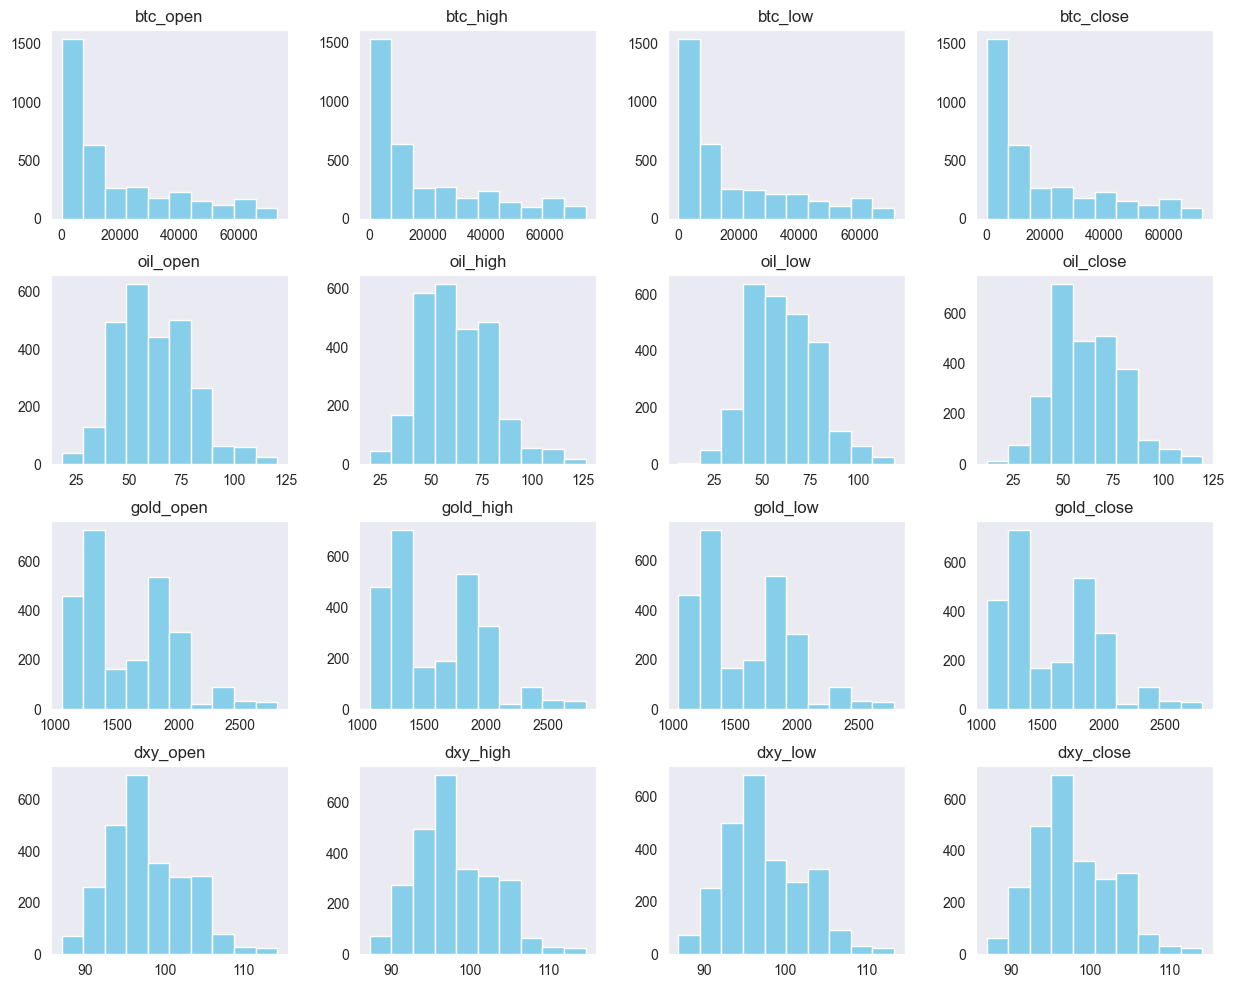

In [571]:
df.drop(columns=['Date', 'Month', 'Year', 'is_holiday', 'is_weekday']).hist(grid=False, color='skyblue', figsize=(15, 12) )
plt.plot()

##### **Correlation Analysis**

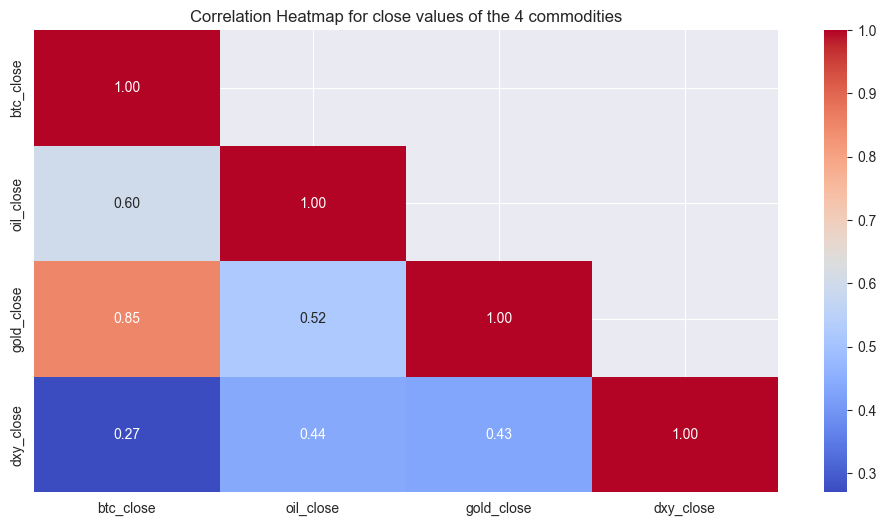

In [572]:
correlation_matrix = df[['btc_close', 'oil_close', 'gold_close', 'dxy_close']].corr().round(2)

# Modify the mask to exclude the diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Plot the heatmap with the modified mask to include the diagonal
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Heatmap for close values of the 4 commodities")
plt.show()

##### **Time Series Analysis**

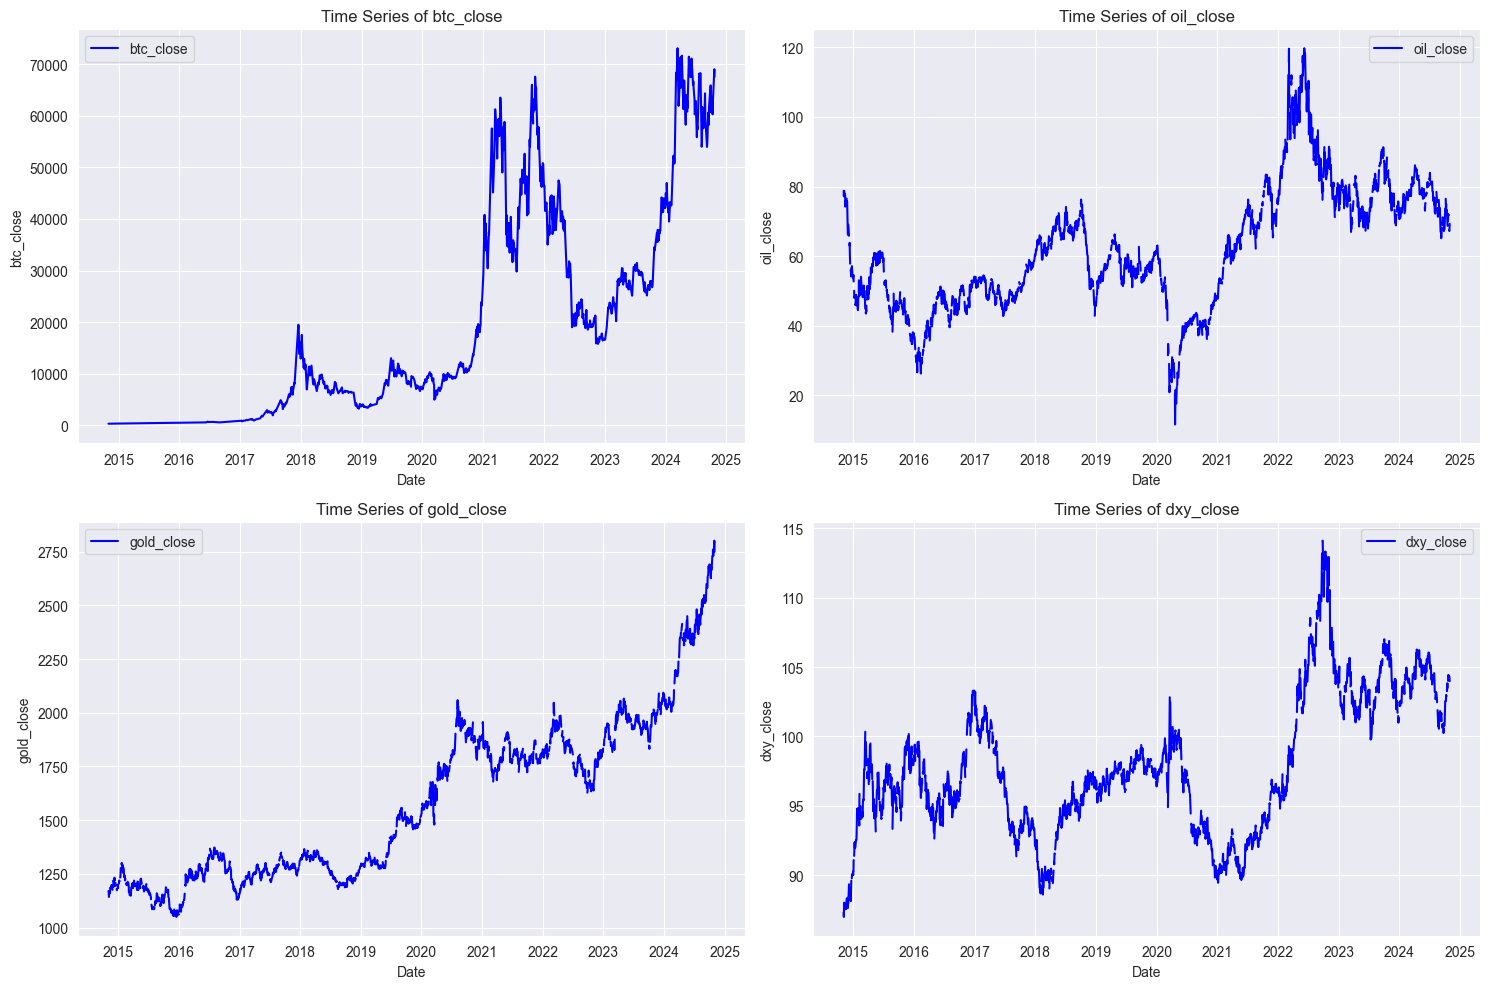

In [573]:
# Set Date as the index for time series analysis
df.set_index('Date', inplace=True)

# Ensure the dataset is sorted by date in ascending order
df = df.sort_index(ascending=True)


# List of variables to analyze
variables = ['btc_close', 'oil_close', 'gold_close', 'dxy_close']

# Plot time series of each variable
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables):
    plt.subplot(2, 2, i+1)
    plt.plot(df[var], label=var, color='blue')
    plt.title(f"Time Series of {var}")
    plt.xlabel("Date")
    plt.ylabel(var)
    plt.legend()

plt.tight_layout()
plt.show()

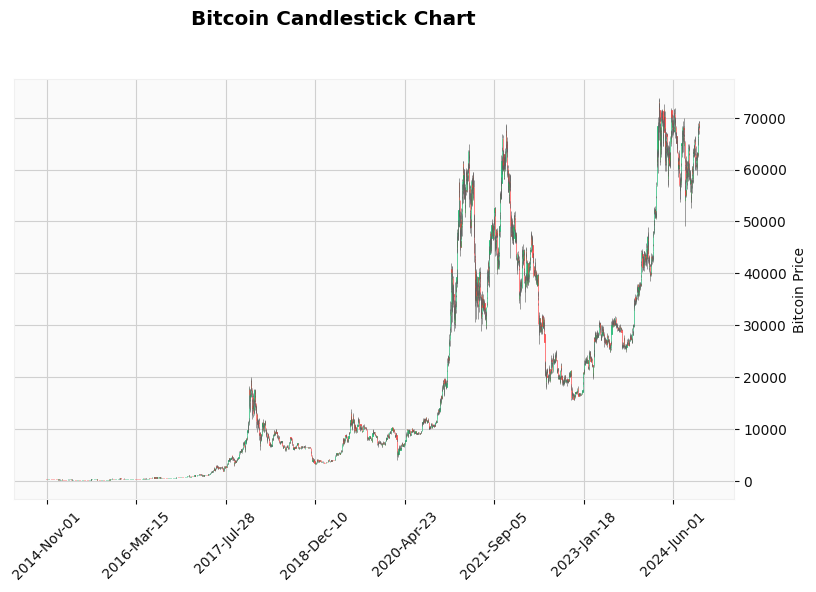

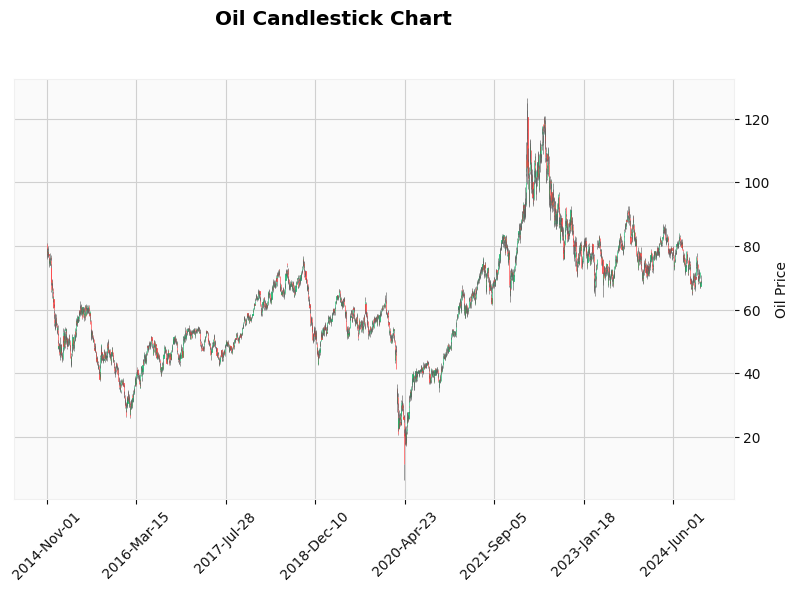

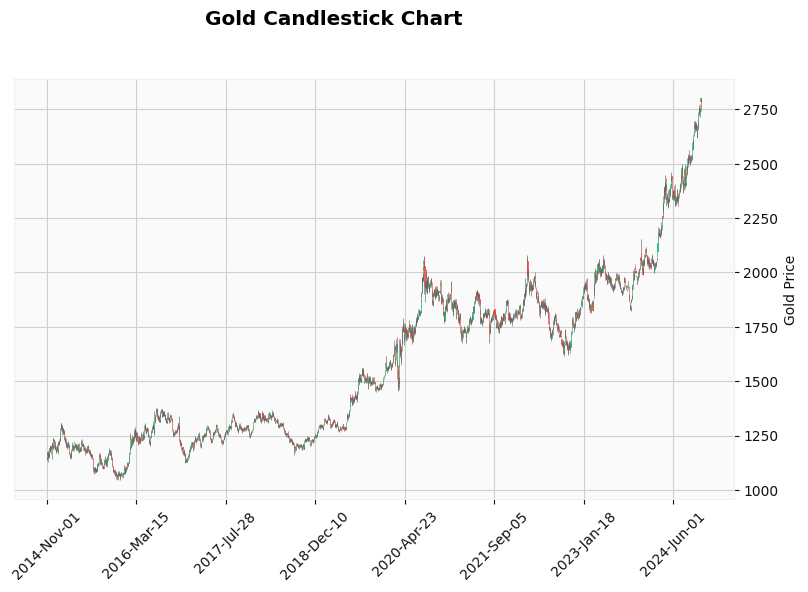

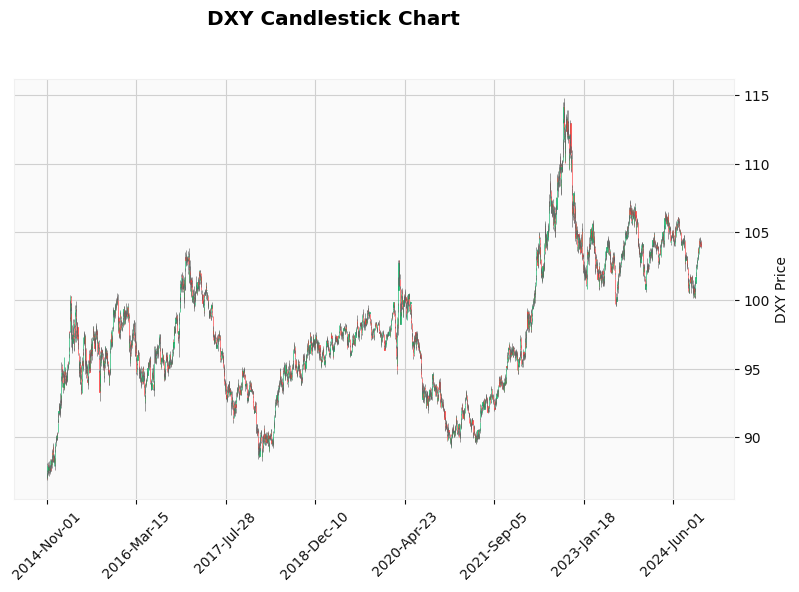

In [574]:
# List of commodities and their relevant columns
commodities = {
    'Bitcoin': ['btc_open', 'btc_high', 'btc_low', 'btc_close'],
    'Oil': ['oil_open', 'oil_high', 'oil_low', 'oil_close'],
    'Gold': ['gold_open', 'gold_high', 'gold_low', 'gold_close'],
    'DXY': ['dxy_open', 'dxy_high', 'dxy_low', 'dxy_close']
}

# Plot candlestick charts for each commodity
for name, columns in commodities.items():
    # Subset the data for the specific commodity
    df_commodity = df[columns]
    df_commodity.columns = ['Open', 'High', 'Low', 'Close']  # Rename for mplfinance compatibility
    df_commodity['Date'] = df.index  # Reset Date from index
    df_commodity.set_index('Date', inplace=True)
    
    # Generate the candlestick chart
    mpf.plot(
        df_commodity,
        type='candle',
        title=f'{name} Candlestick Chart',
        style='yahoo',
        ylabel=f'{name} Price',
        figsize=(10, 6)
    )

##### **Additive and Multiplicative Decompositions**

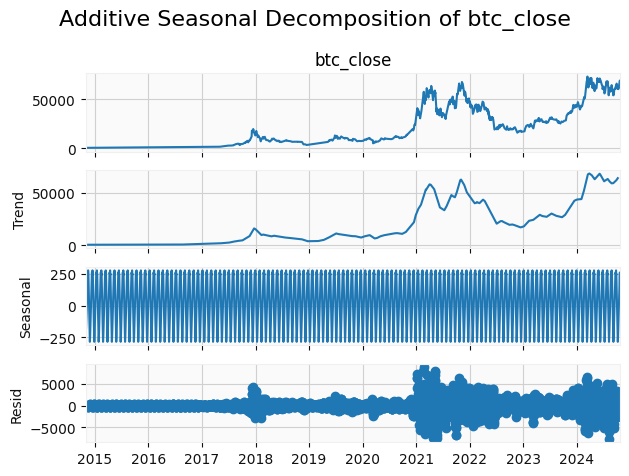

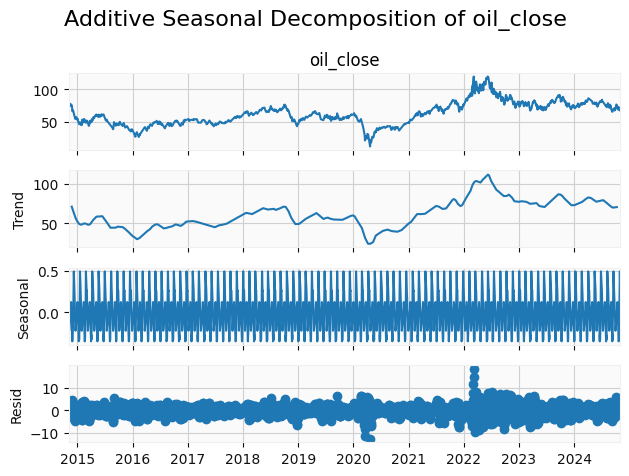

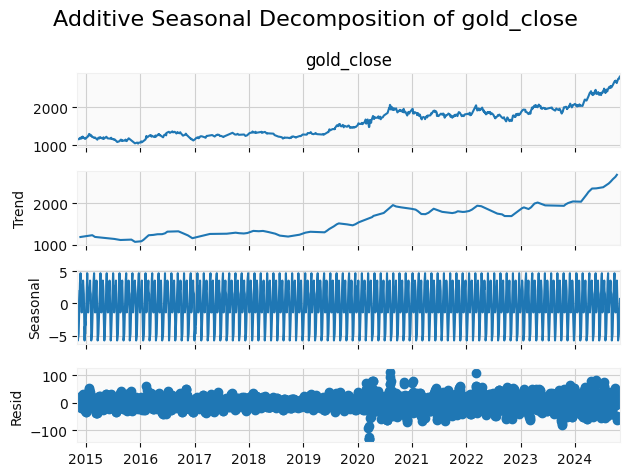

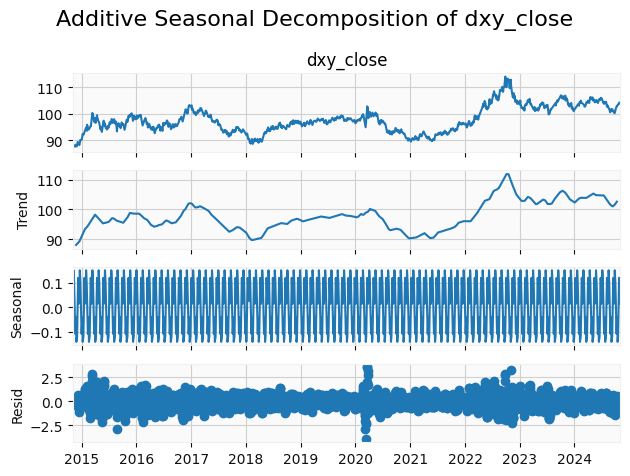

In [575]:
for variable in variables:
    decomposition = seasonal_decompose(df[variable].dropna(), model='additive', period=30)
    fig = decomposition.plot()
    fig.suptitle("") 
    plt.subplots_adjust(top=0.85) 
    plt.gcf().text(0.5, 0.95, f"Additive Seasonal Decomposition of {variable}", fontsize=16, ha='center') 
    plt.show()

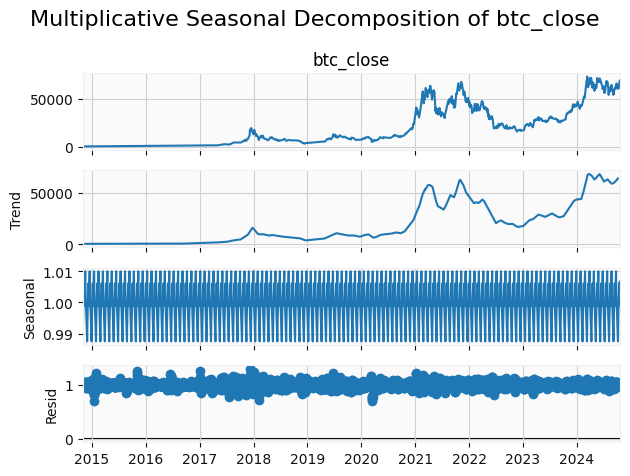

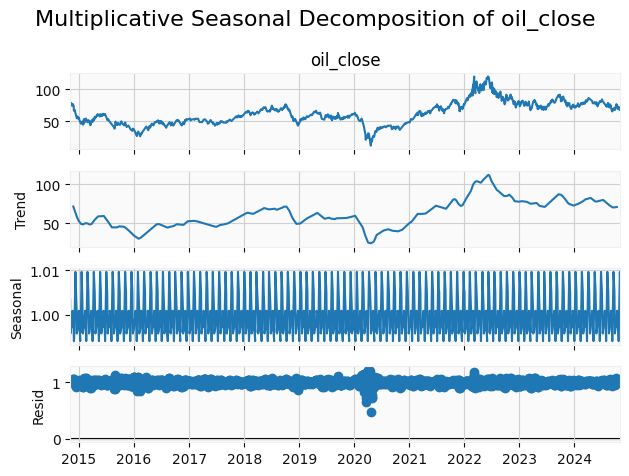

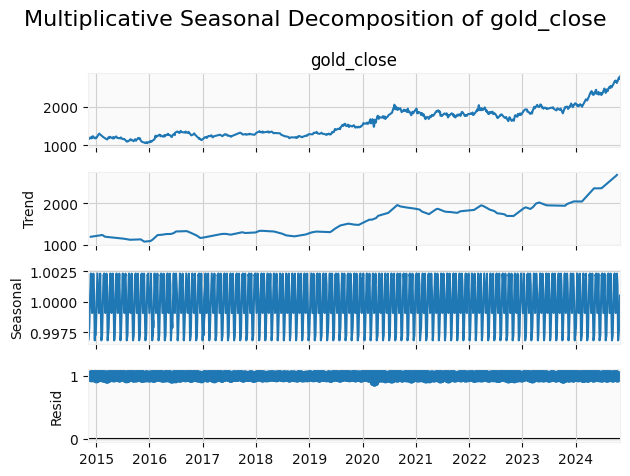

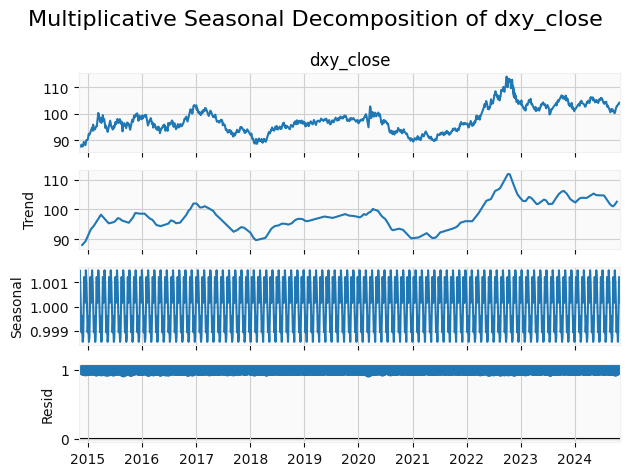

In [576]:
for variable in variables:
    decomposition = seasonal_decompose(df[variable].dropna(), model='multiplicative', period=30)
    fig = decomposition.plot()
    fig.suptitle("") 
    plt.subplots_adjust(top=0.85)  
    plt.gcf().text(0.5, 0.95, f"Multiplicative Seasonal Decomposition of {variable}", fontsize=16, ha='center')  
    plt.show()

##### **Outlier Analysis**

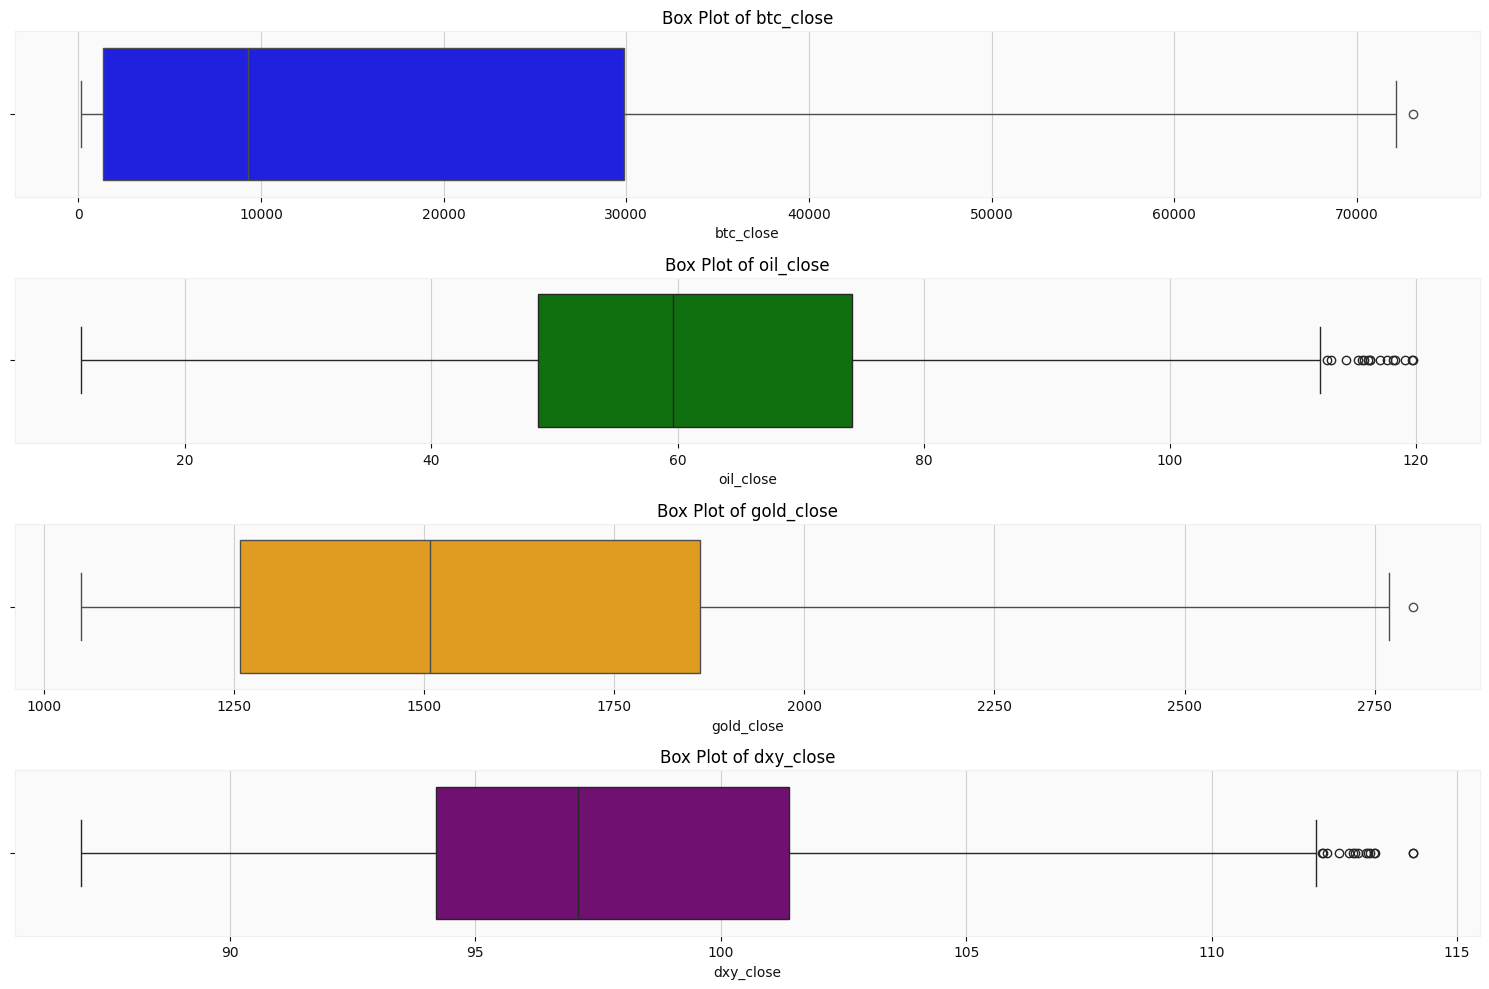

In [577]:
# List of columns to create boxplots for
variables = ['btc_close', 'oil_close', 'gold_close', 'dxy_close']
colors = ['blue', 'green', 'orange', 'purple']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 10), sharex=False)

# Generate horizontal boxplots for each variable
for i, var in enumerate(variables):
    sns.boxplot(x=df[var], ax=axes[i], orient='h', color=colors[i])
    axes[i].set_title(f"Box Plot of {var}")
    axes[i].set_xlabel(var)

# Adjust layout
plt.tight_layout()
plt.show()

In [578]:
# Step 1: Calculate historical ratios for each feature
btc_open_ratio = (df['btc_open'] / df['btc_close']).mean().round(3)
btc_high_ratio = (df['btc_high'] / df['btc_close']).mean().round(3)
btc_low_ratio = (df['btc_low'] / df['btc_close']).mean().round(3)

gold_open_ratio = (df['gold_open'] / df['gold_close']).mean().round(3)
gold_high_ratio = (df['gold_high'] / df['gold_close']).mean().round(3)
gold_low_ratio = (df['gold_low'] / df['gold_close']).mean().round(3)

oil_open_ratio = (df['oil_open'] / df['oil_close']).mean().round(3)
oil_high_ratio = (df['oil_high'] / df['oil_close']).mean().round(3)
oil_low_ratio = (df['oil_low'] / df['oil_close']).mean().round(3)

In [579]:
# Store the ratios in a dictionary
ratios_dict = {
    "btc_open_ratio": btc_open_ratio,
    "btc_high_ratio": btc_high_ratio,
    "btc_low_ratio": btc_low_ratio,
    "gold_open_ratio": gold_open_ratio,
    "gold_high_ratio": gold_high_ratio,
    "gold_low_ratio": gold_low_ratio,
    "oil_open_ratio": oil_open_ratio,
    "oil_high_ratio": oil_high_ratio,
    "oil_low_ratio": oil_low_ratio,
}

# Print the dictionary
ratios_dict

{'btc_open_ratio': 0.999,
 'btc_high_ratio': 1.021,
 'btc_low_ratio': 0.977,
 'gold_open_ratio': 1.0,
 'gold_high_ratio': 1.007,
 'gold_low_ratio': 0.994,
 'oil_open_ratio': 1.001,
 'oil_high_ratio': 1.018,
 'oil_low_ratio': 0.982}

### **`Data Preparation`**

##### **Imputation missing values using `Linear Interpolation`**
- `Gold`, `oil`, `dxy` related Columns don't have missing values, unless it's a holiday or weekend.
- For `BTC` we don't have null values except 1st 10 rows

**Decision:** using Linear interploation for imputing null values 

In [580]:
df.isna().sum()

DoW              0
Month            0
Year             0
btc_open        10
btc_high        10
btc_low         10
btc_close       10
oil_open      1016
oil_high      1016
oil_low       1016
oil_close     1016
gold_open     1089
gold_high     1089
gold_low      1089
gold_close    1089
dxy_open      1043
dxy_high      1043
dxy_low       1043
dxy_close     1043
is_holiday       0
is_weekday       0
dtype: int64

In [581]:
# Imputing missing values in the oil, gold, and dollar data with interpolation
cols = ['btc_open', 'btc_high', 'btc_low', 'btc_close',
        'oil_open', 'oil_high', 'oil_low', 'oil_close',
         'gold_open', 'gold_high', 'gold_low', 'gold_close',
        'dxy_close', 'dxy_open', 'dxy_high', 'dxy_low']

df[cols] = df[cols].interpolate(method='linear', axis=0)

In [582]:
df.head()

,DoW,Month,Year,btc_open,btc_high,btc_low,btc_close,oil_open,oil_high,oil_low,oil_close,gold_open,gold_high,gold_low,gold_close,dxy_open,dxy_high,dxy_low,dxy_close,is_holiday,is_weekday
Date,,,,,,,,,,,,,,,,,,,,,
2014-11-01,Saturday,11,2014,338.65,340.53,321.05,325.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2014-11-02,Sunday,11,2014,326.08,329.05,320.63,325.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2014-11-03,Monday,11,2014,325.57,334.00,325.48,327.55,80.59,80.98,78.08,78.78,1171.1,1173.4,1161.0,1169.8,87.08,87.41,87.02,87.31,0,1
2014-11-04,Tuesday,11,2014,327.16,331.77,325.08,330.49,78.22,78.41,75.84,77.19,1164.6,1175.0,1163.4,1167.7,87.25,87.30,86.88,86.98,0,1
2014-11-05,Wednesday,11,2014,330.68,343.37,330.68,339.49,77.36,79.35,76.46,78.68,1168.4,1169.3,1137.1,1145.7,87.01,87.61,86.94,87.44,0,1


#### **Feature Engineering**

- Creating weekly and monthly moving averages Based on Close Prices
- Creating weekly and monthly percentage change in moving averages
- Creating Daily percentage changes for all 4 commodities
- Creating Intraday Volatility
- Creating day by day percentage change
- Creating volatility on different windows


In [583]:
def feature_engineering(df):

    # List of price columns
    price_cols = ['btc_close', 'oil_close', 'gold_close', 'dxy_close']

# Calculate running weekly and monthly averages
    for asset in price_cols:
        df[f'{asset}_weekly_avg'] = df[asset].rolling(window=7, min_periods=1).mean()
        df[f'{asset}_monthly_avg'] = df[asset].rolling(window=30, min_periods=1).mean()


    # Calculate rolling avg of daily percentage changes over 7-day and 30-day windows

    for asset in price_cols:
        df[f'{asset}_weekly_avg_pct_change'] = df[f'{asset}_weekly_avg'].pct_change() * 100
        df[f'{asset}_monthly_avg_pct_change'] = df[f'{asset}_monthly_avg'].pct_change() * 100


    # Asset categories and their respective price types
    assets = {
        'btc': ['btc_open', 'btc_close', 'btc_high', 'btc_low'],
        'oil': ['oil_open', 'oil_close', 'oil_high', 'oil_low'],
        'gold': ['gold_open', 'gold_close', 'gold_high', 'gold_low'],
        'dxy': ['dxy_open', 'dxy_close', 'dxy_high', 'dxy_low']
    }

    # Calculate daily percentage changes
    for asset, cols in assets.items():
        open_col, close_col, high_col, low_col = cols
        df[f'{asset}_Daily_ocpercentage'] = ((df[close_col] - df[open_col]) / df[open_col] * 100)
        df[f'{asset}_Daily_max_percentage'] = ((df[high_col] - df[open_col]) / df[open_col] * 100)
        df[f'{asset}_Daily_min_percentage'] = ((df[low_col] - df[open_col]) / df[open_col] * 100)


        # Calculate intraday volatility as the percentage difference between high and low prices
    assets = ['btc', 'oil', 'gold', 'dxy']  

    for asset in assets:
        df[f'{asset}_intraday_volatility'] = ((df[f'{asset}_high'] - df[f'{asset}_low']) / df[f'{asset}_close']) * 100


    # Calculate rolling volatility of daily percentage changes over 7-day and 30-day windows

    for asset in assets:
        # Daily percentage change
        df[f'{asset}_daily_percentage'] = df[f'{asset}_close'].pct_change() * 100

    
        # Calculate rolling volatilities
    for asset in assets:
        df[f'{asset}_rolling_volatility_7'] = df[f'{asset}_daily_percentage'].rolling(window=7).std()
        df[f'{asset}_rolling_volatility_30'] = df[f'{asset}_daily_percentage'].rolling(window=30).std()

    assets = {
    'btc': ['btc_open', 'btc_close', 'btc_high', 'btc_low'],
    'oil': ['oil_open', 'oil_close', 'oil_high', 'oil_low'],
    'gold': ['gold_open', 'gold_close', 'gold_high', 'gold_low'],
    'dxy': ['dxy_open', 'dxy_close', 'dxy_high', 'dxy_low']
}

    # Calculate yesterday's ocpercentage for each asset
    for asset in assets:
        df[f'{asset}_yesterday_Daily_ocpercentage'] = df[f'{asset}_daily_percentage'].shift(1)

    # Calculate yesterday's intraday volatility for each asset
    for asset in assets:
        df[f'{asset}_yesterday_intraday_volatility'] = df[f'{asset}_intraday_volatility'].shift(1)

    # Calculate yesterday's daily percentage change for each asset
    for asset in assets:
        df[f'{asset}_yesterday_daily_percentage'] = df[f'{asset}_daily_percentage'].shift(1)

    # Calculate yesterday's percent change of weekly and monthly rolling averages for each asset
    for asset in assets:
        df[f'{asset}_yesterday_weekly_avg_pct_change'] = df[f'{asset}_close_weekly_avg_pct_change'].shift(1)
        df[f'{asset}_yesterday_monthly_avg_pct_change'] = df[f'{asset}_close_monthly_avg_pct_change'].shift(1)

    return df


In [584]:
df = feature_engineering(df)
df.head(10)

,DoW,Month,Year,btc_open,btc_high,btc_low,btc_close,oil_open,oil_high,oil_low,oil_close,gold_open,gold_high,gold_low,gold_close,dxy_open,dxy_high,dxy_low,dxy_close,is_holiday,is_weekday,btc_close_weekly_avg,btc_close_monthly_avg,oil_close_weekly_avg,oil_close_monthly_avg,gold_close_weekly_avg,gold_close_monthly_avg,dxy_close_weekly_avg,dxy_close_monthly_avg,btc_close_weekly_avg_pct_change,btc_close_monthly_avg_pct_change,oil_close_weekly_avg_pct_change,oil_close_monthly_avg_pct_change,gold_close_weekly_avg_pct_change,gold_close_monthly_avg_pct_change,dxy_close_weekly_avg_pct_change,dxy_close_monthly_avg_pct_change,btc_Daily_ocpercentage,btc_Daily_max_percentage,btc_Daily_min_percentage,oil_Daily_ocpercentage,oil_Daily_max_percentage,oil_Daily_min_percentage,gold_Daily_ocpercentage,gold_Daily_max_percentage,gold_Daily_min_percentage,dxy_Daily_ocpercentage,dxy_Daily_max_percentage,dxy_Daily_min_percentage,btc_intraday_volatility,oil_intraday_volatility,gold_intraday_volatility,dxy_intraday_volatility,btc_daily_percentage,oil_daily_percentage,gold_daily_percentage,dxy_daily_percentage,btc_rolling_volatility_7,btc_rolling_volatility_30,oil_rolling_volatility_7,oil_rolling_volatility_30,gold_rolling_volatility_7,gold_rolling_volatility_30,dxy_rolling_volatility_7,dxy_rolling_volatility_30,btc_yesterday_Daily_ocpercentage,oil_yesterday_Daily_ocpercentage,gold_yesterday_Daily_ocpercentage,dxy_yesterday_Daily_ocpercentage,btc_yesterday_intraday_volatility,oil_yesterday_intraday_volatility,gold_yesterday_intraday_volatility,dxy_yesterday_intraday_volatility,btc_yesterday_daily_percentage,oil_yesterday_daily_percentage,gold_yesterday_daily_percentage,dxy_yesterday_daily_percentage,btc_yesterday_weekly_avg_pct_change,btc_yesterday_monthly_avg_pct_change,oil_yesterday_weekly_avg_pct_change,oil_yesterday_monthly_avg_pct_change,gold_yesterday_weekly_avg_pct_change,gold_yesterday_monthly_avg_pct_change,dxy_yesterday_weekly_avg_pct_change,dxy_yesterday_monthly_avg_pct_change
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-11-01,Saturday,11,2014,338.65,340.53,321.05,325.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,325.750000,325.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.809243,0.555145,-5.197106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.980046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-02,Sunday,11,2014,326.08,329.05,320.63,325.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,325.820000,325.820000,NaN,NaN,NaN,NaN,NaN,NaN,0.021489,0.021489,NaN,NaN,NaN,NaN,NaN,NaN,-0.058268,0.910819,-1.671369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.583694,NaN,NaN,NaN,0.042978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.980046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-03,Monday,11,2014,325.57,334.00,325.48,327.55,80.590000,80.980000,78.080000,78.780000,1171.100000,1173.4,1161.000000,1169.800000,87.08,87.41,87.020000,87.310000,0,1,326.396667,326.396667,78.780000,78.780000,1169.800000,1169.800000,87.310000,87.310000,0.176989,0.176989,NaN,NaN,NaN,NaN,NaN,NaN,0.608164,2.589305,-0.027644,-2.245936,0.483931,-3.114530,-0.111007,0.196397,-0.862437,0.264125,0.378962,-0.068902,2.601130,3.681137,1.060010,0.446684,0.509374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042978,NaN,NaN,NaN,2.583694,NaN,NaN,NaN,0.042978,NaN,NaN,NaN,0.021489,0.021489,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-04,Tuesday,11,2014,327.16,331.77,325.08,330.49,78.220000,78.410000,75.840000,77.190000,1164.600000,1175.0,1163.400000,1167.700000,87.25,87.30,86.880000,86.980000,0,1,327.420000,327.420000,77.985000,77.985000,1168.750000,1168.750000,87.145000,87.145000,0.313524,0.313524,-1.009139,-1.009139,-0.089759,-0.089759,-0.188982,-0.188982,1.017851,1.409096,-0.635775,-1.316799,0.242905,-3.042700,0.266186,0.893010,-0.103040,-0.309456,0.057307,-0.424069,2.024267,3.329447,0.993406,0.482870,0

In [585]:
def calculate_yesterday_feature_averages(df):
    # List of features with "yesterday" in them
    yesterday_features = [
        'btc_yesterday_Daily_ocpercentage',
        'btc_yesterday_intraday_volatility',
        'btc_yesterday_daily_percentage',
        'btc_yesterday_weekly_avg_pct_change',
        'btc_yesterday_monthly_avg_pct_change',
        'oil_yesterday_Daily_ocpercentage',
        'oil_yesterday_intraday_volatility',
        'oil_yesterday_daily_percentage',
        'oil_yesterday_weekly_avg_pct_change',
        'oil_yesterday_monthly_avg_pct_change',
        'gold_yesterday_Daily_ocpercentage',
        'gold_yesterday_intraday_volatility',
        'gold_yesterday_daily_percentage',
        'gold_yesterday_weekly_avg_pct_change',
        'gold_yesterday_monthly_avg_pct_change'
    ]

    # Compute averages
    averages = {}
    for feature in yesterday_features:
        averages[feature] = df[feature].mean().round(3)

    return averages

![image.png](attachment:image.png)

In [586]:
yesterday_ratios = calculate_yesterday_feature_averages(df)
yesterday_ratios

{'btc_yesterday_Daily_ocpercentage': 0.213,
 'btc_yesterday_intraday_volatility': 4.411,
 'btc_yesterday_daily_percentage': 0.213,
 'btc_yesterday_weekly_avg_pct_change': 0.156,
 'btc_yesterday_monthly_avg_pct_change': 0.148,
 'oil_yesterday_Daily_ocpercentage': 0.027,
 'oil_yesterday_intraday_volatility': 3.531,
 'oil_yesterday_daily_percentage': 0.027,
 'oil_yesterday_weekly_avg_pct_change': -0.0,
 'oil_yesterday_monthly_avg_pct_change': -0.002,
 'gold_yesterday_Daily_ocpercentage': 0.026,
 'gold_yesterday_intraday_volatility': 1.304,
 'gold_yesterday_daily_percentage': 0.026,
 'gold_yesterday_weekly_avg_pct_change': 0.024,
 'gold_yesterday_monthly_avg_pct_change': 0.023}

#### **Interaction Terms**
- **Ratios**
    - gold_oil_ratio
    - gold_btc_ratio
    - oil_btc_ratio
- **Percentage Difference**
    - dxy_gold
    - dxy_oil
    - dxy_btc



In [587]:
df.columns


Index(['DoW', 'Month', 'Year', 'btc_open', 'btc_high', 'btc_low', 'btc_close',
       'oil_open', 'oil_high', 'oil_low', 'oil_close', 'gold_open',
       'gold_high', 'gold_low', 'gold_close', 'dxy_open', 'dxy_high',
       'dxy_low', 'dxy_close', 'is_holiday', 'is_weekday',
       'btc_close_weekly_avg', 'btc_close_monthly_avg', 'oil_close_weekly_avg',
       'oil_close_monthly_avg', 'gold_close_weekly_avg',
       'gold_close_monthly_avg', 'dxy_close_weekly_avg',
       'dxy_close_monthly_avg', 'btc_close_weekly_avg_pct_change',
       'btc_close_monthly_avg_pct_change', 'oil_close_weekly_avg_pct_change',
       'oil_close_monthly_avg_pct_change', 'gold_close_weekly_avg_pct_change',
       'gold_close_monthly_avg_pct_change', 'dxy_close_weekly_avg_pct_change',
       'dxy_close_monthly_avg_pct_change', 'btc_Daily_ocpercentage',
       'btc_Daily_max_percentage', 'btc_Daily_min_percentage',
       'oil_Daily_ocpercentage', 'oil_Daily_max_percentage',
       'oil_Daily_min_percentage',

### **`Modeling and Evaluation`**

#### **Preprocessing data for Modeling**

In [588]:
df['dxy_future_pct_change'] = df['dxy_daily_percentage'].shift(-1)
df['dxy_future_pct_change']

Date
2014-11-01         NaN
2014-11-02         NaN
2014-11-03   -0.377964
2014-11-04    0.528857
2014-11-05    0.651876
2014-11-06   -0.420407
2014-11-07    0.064658
2014-11-08    0.064617
2014-11-09    0.064575
2014-11-10   -0.318870
2014-11-11    0.331315
2014-11-12   -0.170804
2014-11-13   -0.159690
2014-11-14    0.152329
2014-11-15    0.152097
2014-11-16    0.151866
2014-11-17   -0.398044
2014-11-18    0.079927
2014-11-19   -0.068454
2014-11-20    0.822012
2014-11-21   -0.060393
2014-11-22   -0.060430
2014-11-23   -0.060466
2014-11-24   -0.260919
2014-11-25   -0.352593
2014-11-26    0.000000
2014-11-27    0.856067
2014-11-28   -0.154670
2014-11-29   -0.154910
2014-11-30   -0.155150
2014-12-01    0.795907
2014-12-02    0.349690
2014-12-03   -0.292266
2014-12-04    0.710259
2014-12-05   -0.108213
2014-12-06   -0.108330
2014-12-07   -0.108448
2014-12-08   -0.393082
2014-12-09   -0.473560
2014-12-10    0.441826
2014-12-11   -0.338371
2014-12-12    0.037724
2014-12-13    0.037710
2014-1

In [589]:
df.dropna(subset=["dxy_future_pct_change"], inplace=True)

In [590]:
df.head()

,DoW,Month,Year,btc_open,btc_high,btc_low,btc_close,oil_open,oil_high,oil_low,oil_close,gold_open,gold_high,gold_low,gold_close,dxy_open,dxy_high,dxy_low,dxy_close,is_holiday,is_weekday,btc_close_weekly_avg,btc_close_monthly_avg,oil_close_weekly_avg,oil_close_monthly_avg,gold_close_weekly_avg,gold_close_monthly_avg,dxy_close_weekly_avg,dxy_close_monthly_avg,btc_close_weekly_avg_pct_change,btc_close_monthly_avg_pct_change,oil_close_weekly_avg_pct_change,oil_close_monthly_avg_pct_change,gold_close_weekly_avg_pct_change,gold_close_monthly_avg_pct_change,dxy_close_weekly_avg_pct_change,dxy_close_monthly_avg_pct_change,btc_Daily_ocpercentage,btc_Daily_max_percentage,btc_Daily_min_percentage,oil_Daily_ocpercentage,oil_Daily_max_percentage,oil_Daily_min_percentage,gold_Daily_ocpercentage,gold_Daily_max_percentage,gold_Daily_min_percentage,dxy_Daily_ocpercentage,dxy_Daily_max_percentage,dxy_Daily_min_percentage,btc_intraday_volatility,oil_intraday_volatility,gold_intraday_volatility,dxy_intraday_volatility,btc_daily_percentage,oil_daily_percentage,gold_daily_percentage,dxy_daily_percentage,btc_rolling_volatility_7,btc_rolling_volatility_30,oil_rolling_volatility_7,oil_rolling_volatility_30,gold_rolling_volatility_7,gold_rolling_volatility_30,dxy_rolling_volatility_7,dxy_rolling_volatility_30,btc_yesterday_Daily_ocpercentage,oil_yesterday_Daily_ocpercentage,gold_yesterday_Daily_ocpercentage,dxy_yesterday_Daily_ocpercentage,btc_yesterday_intraday_volatility,oil_yesterday_intraday_volatility,gold_yesterday_intraday_volatility,dxy_yesterday_intraday_volatility,btc_yesterday_daily_percentage,oil_yesterday_daily_percentage,gold_yesterday_daily_percentage,dxy_yesterday_daily_percentage,btc_yesterday_weekly_avg_pct_change,btc_yesterday_monthly_avg_pct_change,oil_yesterday_weekly_avg_pct_change,oil_yesterday_monthly_avg_pct_change,gold_yesterday_weekly_avg_pct_change,gold_yesterday_monthly_avg_pct_change,dxy_yesterday_weekly_avg_pct_change,dxy_yesterday_monthly_avg_pct_change,dxy_future_pct_change
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-11-03,Monday,11,2014,325.57,334.00,325.48,327.55,80.59,80.98,78.08,78.78,1171.1,1173.4,1161.0,1169.8,87.08,87.41,87.02,87.31,0,1,326.396667,326.396667,78.780000,78.780000,1169.800000,1169.800000,87.310000,87.310000,0.176989,0.176989,NaN,NaN,NaN,NaN,NaN,NaN,0.608164,2.589305,-0.027644,-2.245936,0.483931,-3.114530,-0.111007,0.196397,-0.862437,0.264125,0.378962,-0.068902,2.601130,3.681137,1.060010,0.446684,0.509374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042978,NaN,NaN,NaN,2.583694,NaN,NaN,NaN,0.042978,NaN,NaN,NaN,0.021489,0.021489,NaN,NaN,NaN,NaN,NaN,NaN,-0.377964
2014-11-04,Tuesday,11,2014,327.16,331.77,325.08,330.49,78.22,78.41,75.84,77.19,1164.6,1175.0,1163.4,1167.7,87.25,87.30,86.88,86.98,0,1,327.420000,327.420000,77.985000,77.985000,1168.750000,1168.750000,87.145000,87.145000,0.313524,0.313524,-1.009139,-1.009139,-0.089759,-0.089759,-0.188982,-0.188982,1.017851,1.409096,-0.635775,-1.316799,0.242905,-3.042700,0.266186,0.893010,-0.103040,-0.309456,0.057307,-0.424069,2.024267,3.329447,0.993406,0.482870,0.897573,-2.018279,-0.179518,-0.377964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.509374,NaN,NaN,NaN,2.601130,3.681137,1.060010,0.446684,0.509374,NaN,NaN,NaN,0.176989,0.176989,NaN,NaN,NaN,NaN,NaN,NaN,0.528857
2014-11-05,Wednesday,11,2014,330.68,343.37,330.68,339.49,77.36,79.35,76.46,78.68,1168.4,1169.3,1137.1,1145.7,87.01,87.61,86.94,87.44,0,1,329.834000,329.834000,78.216667,78.216667,1161.066667,1161.066667,87.243333,87.243333,0.737279,0.737279,0.297066,0.297066,-0.657398,-0.657398,0.112839,0.112839,2.664207,3.837547,0.000000,1.706308,2.572389,-1.163392,-1.942828,0.077028,-2.678877,0.494196,0.689576,-0.080451,3.737960,3.673106,2.810509,0.766240,2.723229,1.930302,-1.884046,0.528857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.897573,-2.018279,-0.179518,-0.377964,2.024267,3.329447,0.993406,0.482870,0.897573,-2.018279,-0.179518,-0.377964,0.313524,0.313524,-1.009139,-1.00913

In [591]:
df.isna().sum()

DoW                                       0
Month                                     0
Year                                      0
btc_open                                  0
btc_high                                  0
btc_low                                   0
btc_close                                 0
oil_open                                  0
oil_high                                  0
oil_low                                   0
oil_close                                 0
gold_open                                 0
gold_high                                 0
gold_low                                  0
gold_close                                0
dxy_open                                  0
dxy_high                                  0
dxy_low                                   0
dxy_close                                 0
is_holiday                                0
is_weekday                                0
btc_close_weekly_avg                      0
btc_close_monthly_avg           

In [592]:
df['Movement'] = df['dxy_daily_percentage'].apply(lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Stable'))

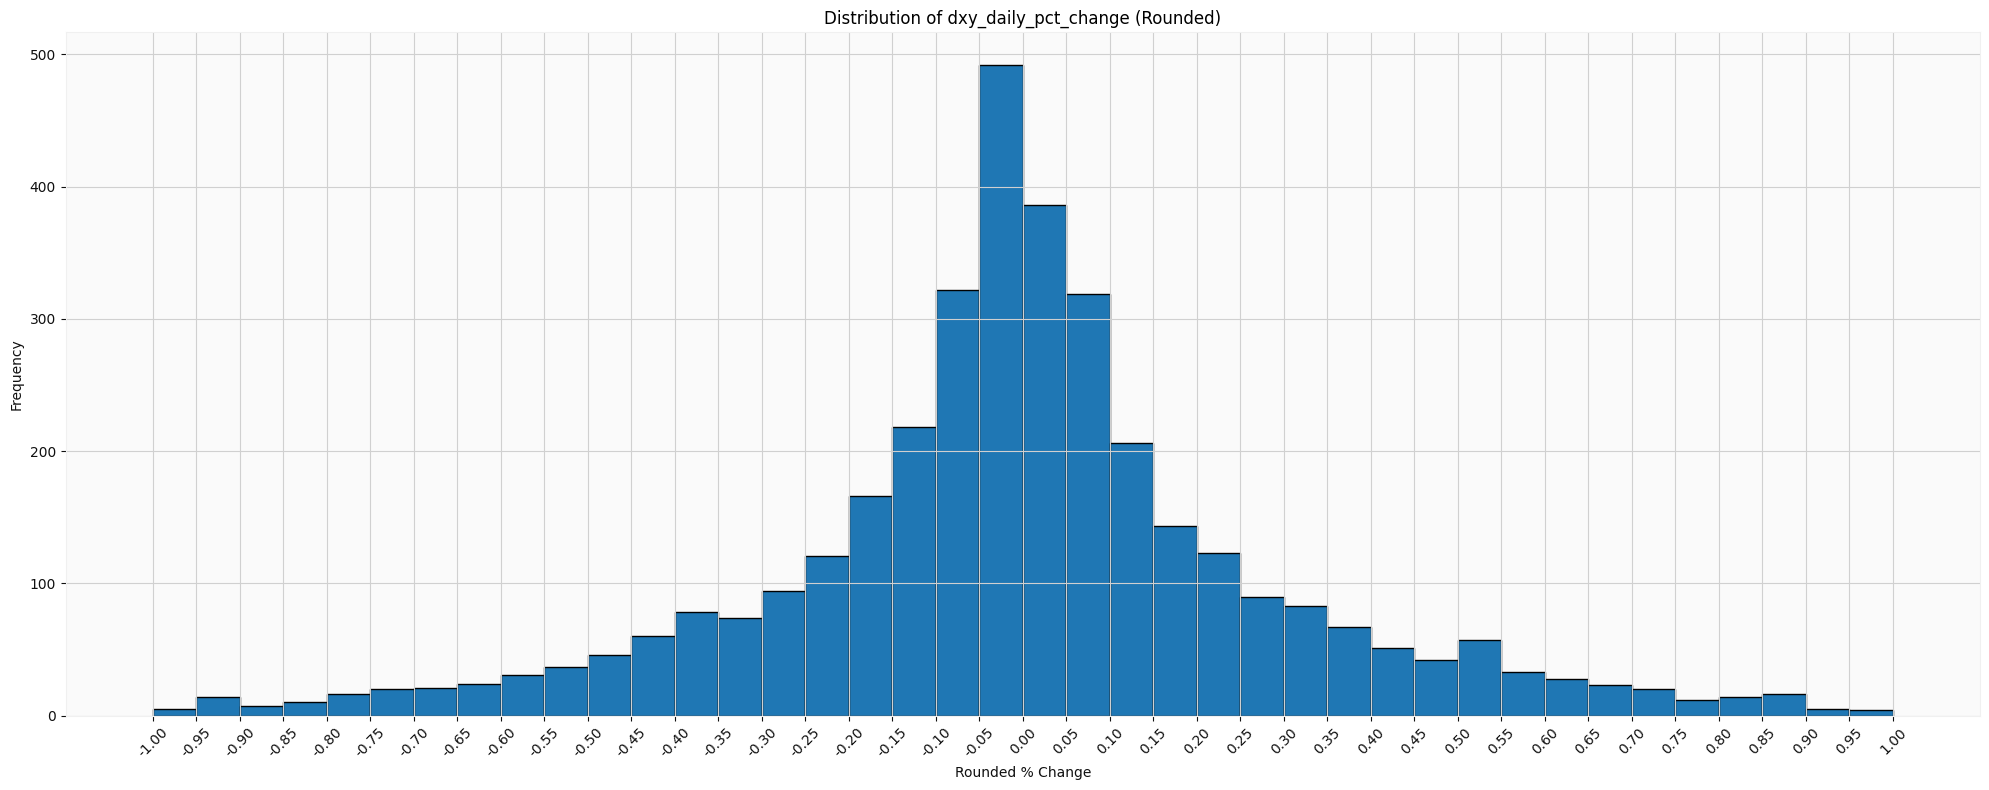

In [593]:
plt.figure(figsize=(20, 8))
# Round the values to two decimal places
df['rounded_pct_change'] = df["dxy_future_pct_change"].round(2)

# Define the bins for intervals (from -1 to 1 with 0.05 intervals)
bins = np.arange(-1, 1.05, 0.05)

# Plot the histogram for visualization
ax = df['rounded_pct_change'].hist(bins=bins, edgecolor='black')

# Set the x-ticks every 0.05, starting from -0.05
x_ticks = np.arange(-1, 1.05, 0.05)
ax.set_xticks(x_ticks)

# Set the x-tick labels to show only the numbers without ranges
ax.set_xticklabels([f'{tick:.2f}' for tick in x_ticks], rotation=45)

# Display the plot
plt.xlabel('Rounded % Change')
plt.ylabel('Frequency')
plt.title('Distribution of dxy_daily_pct_change (Rounded)')

plt.tight_layout() 
plt.show()

In [594]:
df['Movement'].value_counts()

Movement
Positive    1425
Negative    1385
Stable       840
Name: count, dtype: int64

In [595]:
df.isnull().sum()

DoW                                       0
Month                                     0
Year                                      0
btc_open                                  0
btc_high                                  0
btc_low                                   0
btc_close                                 0
oil_open                                  0
oil_high                                  0
oil_low                                   0
oil_close                                 0
gold_open                                 0
gold_high                                 0
gold_low                                  0
gold_close                                0
dxy_open                                  0
dxy_high                                  0
dxy_low                                   0
dxy_close                                 0
is_holiday                                0
is_weekday                                0
btc_close_weekly_avg                      0
btc_close_monthly_avg           

In [596]:
# Drop rows with null values
df = df.dropna()  

In [597]:
# One-hot encode 'DoW' column
df = pd.get_dummies(df, columns=['DoW'], drop_first=False)  

In [598]:
df = df.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

In [599]:
df.dtypes

Month                                      int64
Year                                       int64
btc_open                                 float64
btc_high                                 float64
btc_low                                  float64
btc_close                                float64
oil_open                                 float64
oil_high                                 float64
oil_low                                  float64
oil_close                                float64
gold_open                                float64
gold_high                                float64
gold_low                                 float64
gold_close                               float64
dxy_open                                 float64
dxy_high                                 float64
dxy_low                                  float64
dxy_close                                float64
is_holiday                                 int32
is_weekday                                 int32
btc_close_weekly_avg

#### **Feature Selection**
- Checking multicollinearity
- Feature Selection Based on minimizing VIF

In [600]:
# Compute VIF for each feature
data = add_constant(df.drop(columns=['Movement']))

vif_data = pd.DataFrame()
vif_data['feature'] = data.columns
vif_data['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

vif_data.sort_values(by='VIF', ascending=False)

,feature,VIF
93,DoW_Wednesday,inf
65,btc_yesterday_Daily_ocpercentage,inf
74,oil_yesterday_daily_percentage,inf
73,btc_yesterday_daily_percentage,inf
68,dxy_yesterday_Daily_ocpercentage,inf
67,gold_yesterday_Daily_ocpercentage,inf
20,is_weekday,inf
66,oil_yesterday_Daily_ocpercentage,inf
76,dxy_yesterday_daily_percentage,inf
87,DoW_Friday,inf


- Removing all Price columns (original columns)
- Removing All DXY related columns. (Movement is the target variable)
- Removing moving averages (keeping percentage  changes)

In [601]:
df_final = df[['Month', 'Year',
                'is_holiday', 
                'btc_intraday_volatility', 'oil_intraday_volatility', 'gold_intraday_volatility',       # int_vlt
                'btc_daily_percentage', 'oil_daily_percentage', 'gold_daily_percentage',                # daily_pct
                'btc_rolling_volatility_7', 'btc_rolling_volatility_30',                                # RA_vlt
                'oil_rolling_volatility_7', 'oil_rolling_volatility_30',                                # RA_vlt
                'gold_rolling_volatility_7', 'gold_rolling_volatility_30',                              # RA_vlt
                'btc_yesterday_intraday_volatility', 'oil_yesterday_intraday_volatility','gold_yesterday_intraday_volatility',      #yesterday
                'btc_yesterday_daily_percentage', 'oil_yesterday_daily_percentage', 'gold_yesterday_daily_percentage',  #yesterday
                'btc_yesterday_weekly_avg_pct_change', 'btc_yesterday_monthly_avg_pct_change',      #yesterday         #pct_MA
                'oil_yesterday_weekly_avg_pct_change', 'oil_yesterday_monthly_avg_pct_change',        #yesterday     #pct_MA
                'gold_yesterday_weekly_avg_pct_change','gold_yesterday_monthly_avg_pct_change',         #yesterday      #pct_MA
                'Movement',                                                                             # target
                 ]]

In [602]:
# Compute VIF for each feature
data = add_constant(df_final.drop(columns=['Movement']))

vif_data = pd.DataFrame()
vif_data['feature'] = data.columns
vif_data['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

vif_data.sort_values(by='VIF', ascending=False)

,feature,VIF
0,const,534899.793221
10,btc_rolling_volatility_7,3.014559
17,oil_yesterday_intraday_volatility,2.900179
12,oil_rolling_volatility_7,2.607341
13,oil_rolling_volatility_30,2.439758
15,gold_rolling_volatility_30,2.376688
11,btc_rolling_volatility_30,2.178595
5,oil_intraday_volatility,2.097729
14,gold_rolling_volatility_7,1.902491
16,btc_yesterday_intraday_volatility,1.890638


In [603]:
# Divide data into X and Y variables
X = df_final.drop(columns=['Movement'])
y = df_final['Movement']

In [604]:
mutual_info_values  = mutual_info_classif(X , y, discrete_features= True )
Columns_to_ = X
mi_df = pd.DataFrame({'Feature': Columns_to_.columns, 'Mutual_Information': mutual_info_values})

mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False)

In [605]:
mi_df

,Feature,Mutual_Information
12,oil_rolling_volatility_30,1.073674
13,gold_rolling_volatility_7,1.073674
10,btc_rolling_volatility_30,1.073674
24,oil_yesterday_monthly_avg_pct_change,1.073674
22,btc_yesterday_monthly_avg_pct_change,1.073674
16,oil_yesterday_intraday_volatility,1.073674
14,gold_rolling_volatility_30,1.073674
11,oil_rolling_volatility_7,1.073674
26,gold_yesterday_monthly_avg_pct_change,1.073674
4,oil_intraday_volatility,1.073291


In [606]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True,random_state=123)

In [607]:
y_train.value_counts()

Movement
Positive    1140
Negative    1083
Stable       673
Name: count, dtype: int64

In [608]:
# Get the value counts for the classes
value_counts = y_train.value_counts()

# Create a DataFrame for Plotly
value_counts_df = pd.DataFrame({'Class': value_counts.index, 'Count': value_counts.values})

# Create the bar chart using Plotly
fig = px.bar(value_counts_df, 
             x='Class', 
             y='Count', 
             title='Class Distribution of Train Data', 
             labels={'Class': 'Class', 'Count': 'Number of Instances'}, 
             color='Class',
             text='Count')

fig.show()

In [609]:
input_features = X.columns
input_features

Index(['Month', 'Year', 'is_holiday', 'btc_intraday_volatility',
       'oil_intraday_volatility', 'gold_intraday_volatility',
       'btc_daily_percentage', 'oil_daily_percentage', 'gold_daily_percentage',
       'btc_rolling_volatility_7', 'btc_rolling_volatility_30',
       'oil_rolling_volatility_7', 'oil_rolling_volatility_30',
       'gold_rolling_volatility_7', 'gold_rolling_volatility_30',
       'btc_yesterday_intraday_volatility',
       'oil_yesterday_intraday_volatility',
       'gold_yesterday_intraday_volatility', 'btc_yesterday_daily_percentage',
       'oil_yesterday_daily_percentage', 'gold_yesterday_daily_percentage',
       'btc_yesterday_weekly_avg_pct_change',
       'btc_yesterday_monthly_avg_pct_change',
       'oil_yesterday_weekly_avg_pct_change',
       'oil_yesterday_monthly_avg_pct_change',
       'gold_yesterday_weekly_avg_pct_change',
       'gold_yesterday_monthly_avg_pct_change'],
      dtype='object')

In [610]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

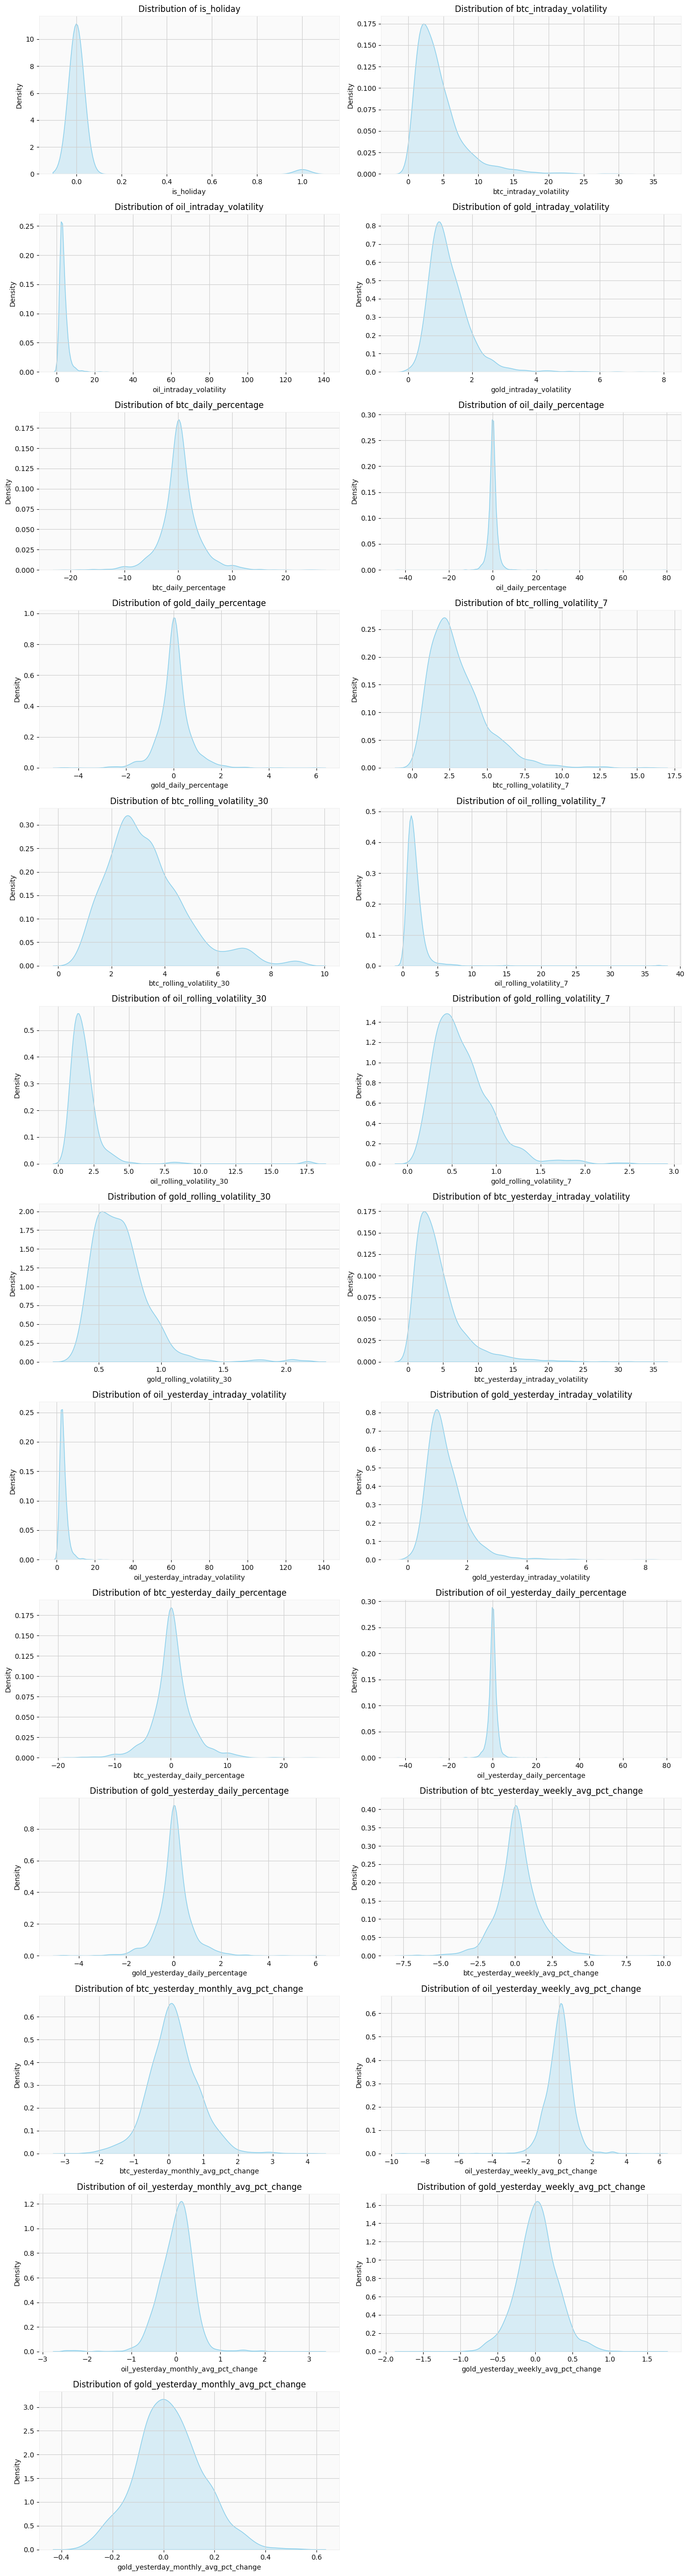

In [611]:
# Columns to exclude from distribution plots
exclude_columns = ['Year', 'IS_HOLIDAY', 'Month', 'IS_WEEKDAY']

# Filter columns to include only relevant ones
columns_to_plot = [col for col in X_train.columns if col not in exclude_columns]

# Set up the grid layout
n_cols = 2  # Number of plots per row
n_rows = math.ceil(len(columns_to_plot) / n_cols)  # Calculate the required rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))

# Flatten axes for easy iteration (handles cases where n_cols != n_rows)
axes = axes.flatten()

# Plot each column
for i, column in enumerate(columns_to_plot):
    sns.kdeplot(X_train[column], fill=True, alpha=0.3, color='skyblue', ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Density')

# Hide any empty subplots
for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

In [612]:
# Automatically categorize features by skewness
skew_threshold = 0.5  
symmetric_columns = []
skewed_columns = []

for column in X_train.columns:
    skewness = X_train[column].skew()
    if abs(skewness) <= skew_threshold:
        symmetric_columns.append(column)
    else:
        skewed_columns.append(column)

In [613]:
symmetric_columns

['Month',
 'Year',
 'btc_daily_percentage',
 'gold_daily_percentage',
 'btc_yesterday_daily_percentage',
 'gold_yesterday_daily_percentage',
 'btc_yesterday_weekly_avg_pct_change',
 'btc_yesterday_monthly_avg_pct_change',
 'gold_yesterday_weekly_avg_pct_change',
 'gold_yesterday_monthly_avg_pct_change']

In [614]:
skewed_columns

['is_holiday',
 'btc_intraday_volatility',
 'oil_intraday_volatility',
 'gold_intraday_volatility',
 'oil_daily_percentage',
 'btc_rolling_volatility_7',
 'btc_rolling_volatility_30',
 'oil_rolling_volatility_7',
 'oil_rolling_volatility_30',
 'gold_rolling_volatility_7',
 'gold_rolling_volatility_30',
 'btc_yesterday_intraday_volatility',
 'oil_yesterday_intraday_volatility',
 'gold_yesterday_intraday_volatility',
 'oil_yesterday_daily_percentage',
 'oil_yesterday_weekly_avg_pct_change',
 'oil_yesterday_monthly_avg_pct_change']

In [615]:
# Define separate pipelines for symmetric and skewed columns
symmetric_pipeline = Pipeline(steps=[
    ('mean_imputer', SimpleImputer(strategy='mean')), 
    ('skew_correction', PowerTransformer(method='yeo-johnson')), 
    ('scaler', RobustScaler()) 
])

skewed_pipeline = Pipeline(steps=[
    ('median_imputer', SimpleImputer(strategy='median')),  
    ('skew_correction', PowerTransformer(method='yeo-johnson')),  
    ('scaler', RobustScaler()) 
])


# Integrate the two pipelines into the preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('symmetric_processing', symmetric_pipeline, symmetric_columns),  
    ('skewed_processing', skewed_pipeline, skewed_columns)  
])

In [616]:
models = [
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('SVC', SVC(random_state=42, probability=True)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('Bagging Classifier', BaggingClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0)),
    ('LightGBM', LGBMClassifier(random_state=42)),
    ('Naive Bayes', GaussianNB()),
    ('KNN', KNeighborsClassifier()),
    ('Extra Trees', ExtraTreesClassifier(random_state=42)),
    ('Neural Network', MLPClassifier(random_state=42, max_iter=500))
]

In [617]:
# Create an ensemble model using majority voting (or weighted voting if you prefer)
voting_estimators = [
     ('Random Forest', RandomForestClassifier(random_state=42)),
     ('Logistic Regression', LogisticRegression(random_state=42)),
     ('XGBoost', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
     # ('SVC', SVC(probability=True, random_state=42)),   
     ('CatBoost', CatBoostClassifier(random_state=42, verbose=0)),
     ('LightGBM', LGBMClassifier(random_state=42)),
]

ensemble_model = VotingClassifier(estimators=voting_estimators, voting='soft')

# Add ensemble model to the models list
models.append(('Voting Classifier', ensemble_model))

In [618]:
# Create an ensemble stacking classifier
base_learners = [
    ('Random Forest', RandomForestClassifier(random_state=42)),  
    ('XGBoost', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0)),  
    ('LightGBM', LGBMClassifier(random_state=42)),
    # ('SVC', SVC(probability=True, random_state=42))  
]

# Set Logistic Regression as the meta learner
meta_learner = SVC(probability=True, random_state=42)

# Configure the StackingClassifier
stacking_classifier = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# Assuming 'models' is a list meant to store different models for further evaluation
models.append(('Stacking Classifier', stacking_classifier))

In [619]:
selection = SelectKBest(mutual_info_classif, k=18)

fi_smote_df = pd.DataFrame(columns=['Model_name', 'Accuracy', 'Precision', 'Recall', 'F1_Score'])

# Dictionary to store all trained pipelines
all_pipelines = {}

# Dictionary to store confusion matrices
confusion_matrices = {} 

for model_name, classifier in models:

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_importance', selection),
        ('classifier', classifier)
    ])

    pipeline.fit(X_train, y_train_encoded)

    all_pipelines[model_name] = pipeline

    smote_y_pred = pipeline.predict(X_test)

    fi_smote_dict = classification_report(y_test_encoded, smote_y_pred, output_dict=True)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test_encoded, smote_y_pred)
    confusion_matrices[model_name] = cm

    accuracy = fi_smote_dict['accuracy']
    precision = fi_smote_dict['weighted avg']['precision']
    recall = fi_smote_dict['weighted avg']['recall']
    f1_score = fi_smote_dict['weighted avg']['f1-score']

    fi_smote_df.loc[len(fi_smote_df)] = [model_name, accuracy, precision, recall, f1_score]


fi_smote_df.sort_values(by='F1_Score', ascending=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3850
[LightGBM] [Info] Number of data points in the train set: 2896, number of used features: 18
[LightGBM] [Info] Start training from score -0.983596
[LightGBM] [Info] Start training from score -0.932302
[LightGBM] [Info] Start training from score -1.459340
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 2896, number of used features: 18
[LightGBM] [Info] Start training from score -0.983596
[LightGBM] [Info] Start training from score -0.932302
[LightGBM] [Info] Start training from score -1.459340
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 secon

,Model_name,Accuracy,Precision,Recall,F1_Score
15,Stacking Classifier,0.689227,0.695964,0.689227,0.688580
12,Extra Trees,0.675414,0.690260,0.675414,0.673668
4,XGBoost,0.672652,0.677470,0.672652,0.670987
5,Bagging Classifier,0.674033,0.678726,0.674033,0.670678
2,Random Forest,0.674033,0.686248,0.674033,0.669121
8,CatBoost,0.665746,0.669993,0.665746,0.664688
9,LightGBM,0.656077,0.659750,0.656077,0.654440
14,Voting Classifier,0.658840,0.668301,0.658840,0.654108
0,Decision Tree,0.570442,0.572562,0.570442,0.571236
7,Gradient Boosting,0.578729,0.578239,0.578729,0.566865


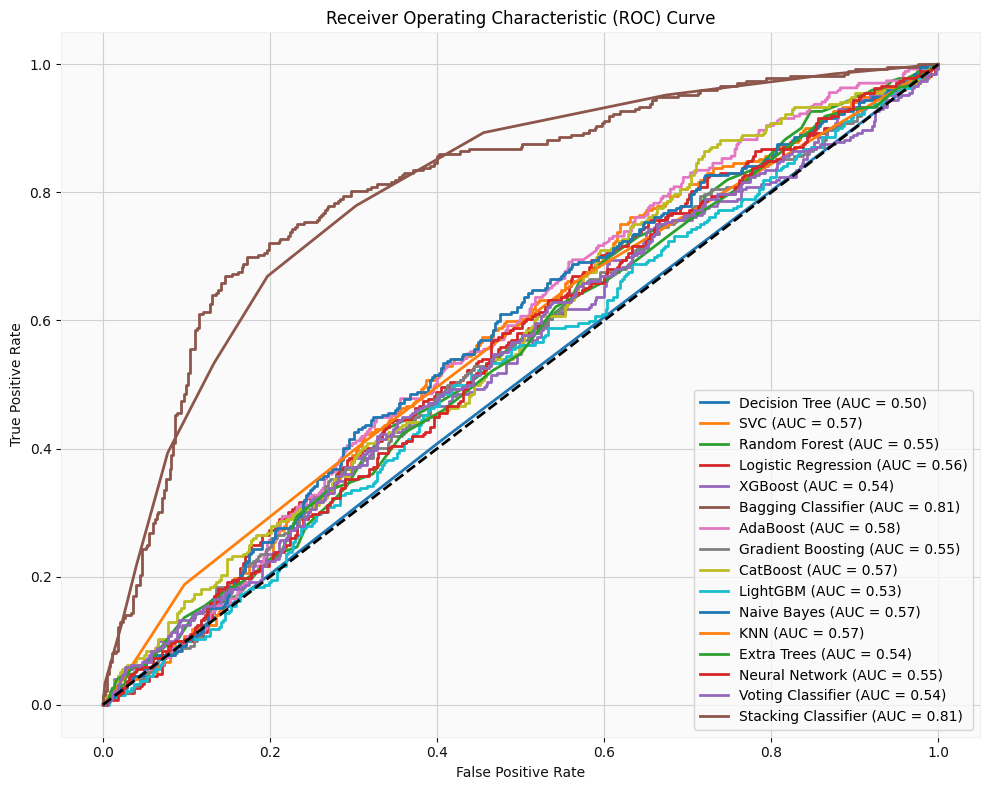

In [620]:
# Initialize the figure
plt.figure(figsize=(10, 8))

# Loop through each model and plot its ROC curve
for model_name, pipeline in all_pipelines.items():
    # Predict probabilities for the positive class (Class 1)
    y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for class 1
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test_encoded, y_prob, pos_label=1)  # Positive class = 1
    roc_auc = auc(fpr, tpr)  # Calculate AUC
    
    # Plot the ROC curve for each model
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (Random classifier line)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()

In [621]:
stacking_classifier = all_pipelines['Stacking Classifier']
stacking_classifier

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('symmetric_processing',
                                                  Pipeline(steps=[('mean_imputer',
                                                                   SimpleImputer()),
                                                                  ('skew_correction',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Month', 'Year',
                                                   'btc_daily_percentage',
                                                   'gold_daily_percentage',
                                                   'btc_yesterday_daily_percentage',
                                                   'gold_yesterday_daily_percentage',
                                                   'btc_yesterday_w...
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=None,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=42, ...)),
                                                ('CatBoost',
                                                 <catboost.core.CatBoostClassifier object at 0x000002869D04B380>),
                                                ('LightGBM',
                                                 LGBMClassifier(random_state=42))],
                                    final_estimator=SVC(probability=True,
                                                        random_state=42)))])

In [622]:
random_forest = all_pipelines['Random Forest']
random_forest

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('symmetric_processing',
                                                  Pipeline(steps=[('mean_imputer',
                                                                   SimpleImputer()),
                                                                  ('skew_correction',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Month', 'Year',
                                                   'btc_daily_percentage',
                                                   'gold_daily_percentage',
                                                   'btc_yesterday_daily_percentage',
                                                   'gold_yesterday_daily_percentage',
                                                   'btc_yesterday_w...
                                                   'btc_yesterday_intraday_volatility',
                                                   'oil_yesterday_intraday_volatility',
                                                   'gold_yesterday_intraday_volatility',
                                                   'oil_yesterday_daily_percentage',
                                                   'oil_yesterday_weekly_avg_pct_change',
                                                   'oil_yesterday_monthly_avg_pct_change'])])),
                ('feature_importance',
                 SelectKBest(k=18,
                             score_func=<function mutual_info_classif at 0x00000286EEF46E80>)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [623]:
print(label_encoder.classes_)

['Negative' 'Positive' 'Stable']


#### **Confusion Matrices of 2 top models**

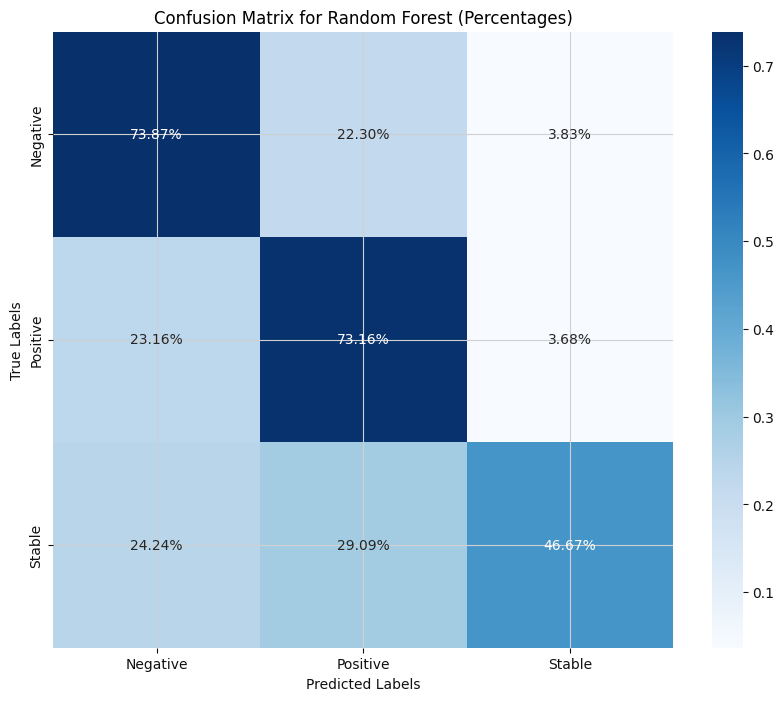

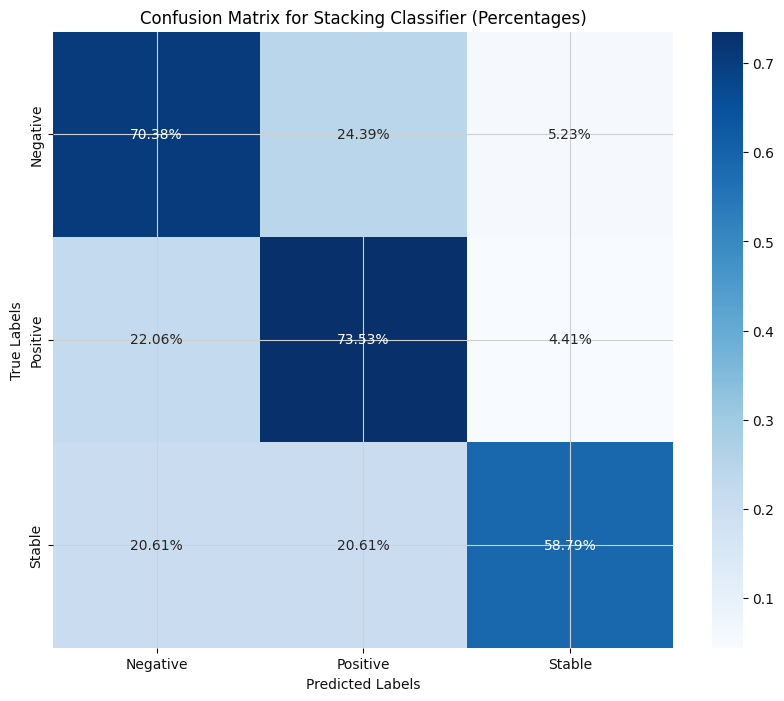

In [624]:
# Dynamically retrieve class labels from label_encoder
class_labels = label_encoder.classes_
top_2_pipelines = ['Stacking Classifier', 'Random Forest']

# Loop through the confusion_matrices dictionary for the top 2 pipelines
for model_name, cm in confusion_matrices.items():
    if model_name in top_2_pipelines:  # Filter for top models
        # Normalize the confusion matrix to percentages (optional)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Create a heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                    xticklabels=class_labels,
                    yticklabels=class_labels)
        
        # Add title and axis labels
        plt.title(f"Confusion Matrix for {model_name} (Percentages)")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        
        # Show the plot
        plt.show()


                             Feature Name     Score
0                 btc_intraday_volatility  0.214900
1              gold_rolling_volatility_30  0.123051
2                gold_intraday_volatility  0.040452
3          btc_yesterday_daily_percentage  0.039433
4    oil_yesterday_monthly_avg_pct_change  0.037461
5         gold_yesterday_daily_percentage  0.029518
6               oil_rolling_volatility_30  0.027041
7   gold_yesterday_monthly_avg_pct_change  0.024351
8       oil_yesterday_intraday_volatility  0.024033
9                   gold_daily_percentage  0.022530
10                   oil_daily_percentage  0.018997
11              btc_rolling_volatility_30  0.013364
12         oil_yesterday_daily_percentage  0.008967
13     gold_yesterday_intraday_volatility  0.008013
14               btc_rolling_volatility_7  0.007267
15                                  Month  0.006484
16                                   Year  0.004878
17                             is_holiday  0.004162
18   btc_yes

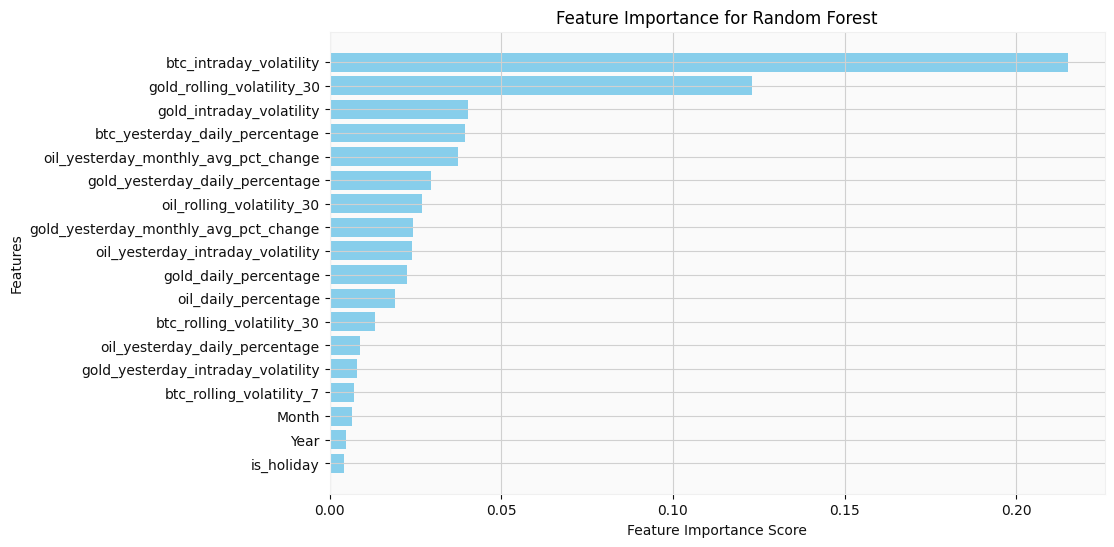

                             Feature Name     Score
0                 btc_intraday_volatility  0.214900
1              gold_rolling_volatility_30  0.123051
2                gold_intraday_volatility  0.040452
3          btc_yesterday_daily_percentage  0.039433
4    oil_yesterday_monthly_avg_pct_change  0.037461
5         gold_yesterday_daily_percentage  0.029518
6               oil_rolling_volatility_30  0.027041
7   gold_yesterday_monthly_avg_pct_change  0.024351
8       oil_yesterday_intraday_volatility  0.024033
9                   gold_daily_percentage  0.022530
10                   oil_daily_percentage  0.018997
11              btc_rolling_volatility_30  0.013364
12         oil_yesterday_daily_percentage  0.008967
13     gold_yesterday_intraday_volatility  0.008013
14               btc_rolling_volatility_7  0.007267
15                                  Month  0.006484
16                                   Year  0.004878
17                             is_holiday  0.004162
18   btc_yes

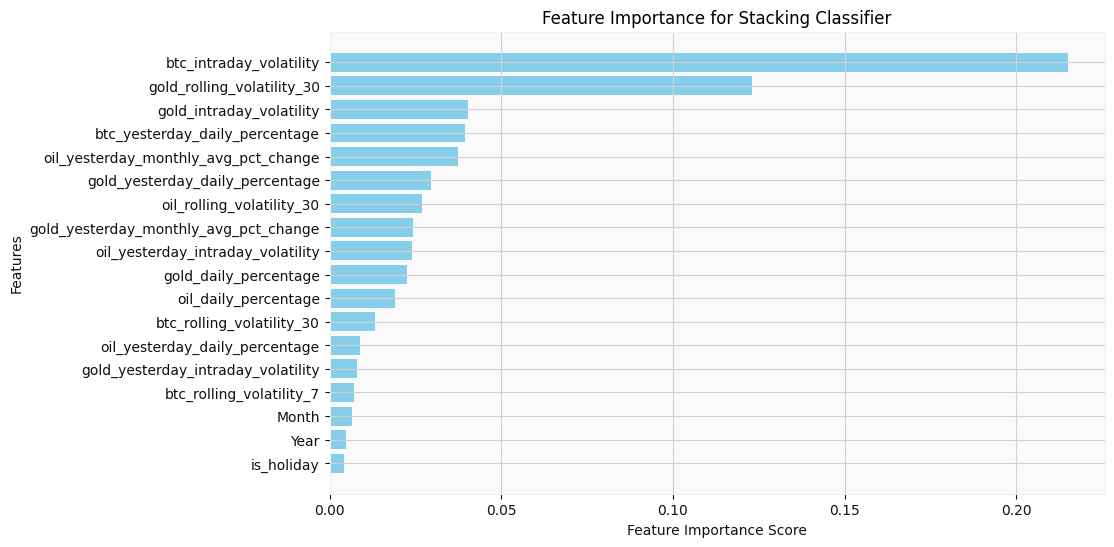

In [625]:
# Loop through each pipeline stored in the all_pipelines dictionary
for model_name, pipeline in all_pipelines.items():

    if model_name in top_2_pipelines: 
        # Get the SelectKBest instance from the pipeline
        selection = pipeline.named_steps['feature_importance']
        
        # Extract feature scores and names
        feature_scores = selection.scores_
        feature_names = X_train.columns  

        # Combine names and scores, then sort by score
        feature_importance = sorted(zip(feature_names, feature_scores), key=lambda x: x[1], reverse=True)
        features, scores = zip(*feature_importance)
        # print(features)
        
        df = pd.DataFrame(feature_importance, columns=['Feature Name', 'Score'])
        
        print(df)
        print(df.columns)
        
        # Match lengths for plotting
        top_n = min(len(features), 18)  # Use the smaller length (e.g., 15 top features)
        
        # Plot the feature importance for this model
        plt.figure(figsize=(10, 6))
        plt.barh(features[:18], scores[:top_n], color='skyblue')  
        plt.xlabel('Feature Importance Score')
        plt.ylabel('Features')
        plt.title(f'Feature Importance for {model_name}')
        plt.gca().invert_yaxis()  
        plt.show()


### **`Deployment`**

In [626]:
# Saving the model
joblib.dump(random_forest, '../models/random_forest.joblib')
joblib.dump(stacking_classifier, '../models/stacking_classifier.joblib')
joblib.dump(label_encoder, '../models/label_encoder.joblib')

['../models/label_encoder.joblib']